<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/airways_predictive_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 6th May, 2024
# Click on the button 'Open in Colab' above to work in colab

## Preliminary

In [238]:
# 0.0 Reset memory when repeating experiment
%reset -f

In [239]:
# We work both in python and R

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [240]:
# 0.1 Print output from mulitple commands in a cell
# Ref: https://stackoverflow.com/a/48036735

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Call libraries
Install software and call libraries. R is used primarily for **[Data Visualization](https://github.com/harnalashok/classification/blob/main/airways_visual_analysis.ipynb)** . Nevertheless, we install and call R libraries in this notebook also.

In [241]:
%%R

# R packages install. Takes time..
# R is used mainly for Data Visualization
# NEvertheless we install and call libraries in this notebook also

install.packages("tidyverse")
install.packages("vcd")
install.packages("vcdExtra")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/tidyverse_2.0.0.tar.gz'
Content type 'application/x-gzip' length 704618 bytes (688 KB)
downloaded 688 KB


The downloaded source packages are in
	‘/tmp/RtmpSrwLbn/downloaded_packages’
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/vcd_1.4-13.tar.gz'
Content type 'application/x-gzip' length 692042 bytes (675 KB)
downloaded 675 KB


The downloaded source packages are in
	‘/tmp/RtmpSrwLbn/downloaded_packages’
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/vcdExtra_0.8-5.tar.gz'
Content type 'application/x-gzip' length 971321 bytes (948 KB)
downloaded 948 KB


The downloaded source packages are in
	‘/tmp/RtmpSrwLbn/downloaded_packages’


In [265]:
#1.1  Data preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

#1.2 Split data into X_train/X_test
from sklearn.model_selection import train_test_split

#1.3 For cross-validation and stratified k-fold partitions
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

#1.4 Encoders
#import category_encoders as ce

#1.5 For plotting/printing
import matplotlib.pyplot as plt
import seaborn as sns
# Pretty-print tabular data in Python, a
import tabulate

#1.6 Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

#1.7 Hyperparameter search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#1.8 Classification reports/metrics
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

# 1.9 Misc.
# Used in hyperparameter search
from scipy.stats import loguniform
import time
import os.path

In [243]:
%%R

# Call R libraries
library(tidyverse)
library(vcd)
library(vcdExtra)

In [244]:
#1.8 Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [245]:
%%R

options(warn=-1)

### Connect to google drive
We will save all results available in pandas dataframe. These can be latter retrieved and used for various reports/graphs.      
Our data directory is: `/gdrive/MyDrive/airways/`

In [246]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Read/examine data

### Read data

In [247]:
# 2.1 Read data from github repo

df=pd.read_csv('https://raw.githubusercontent.com/harnalashok/classification/refs/heads/main/data/airways_mod_ver4.csv')
df.shape   # (1000, 13)

(1000, 13)

In [248]:
%%R

# 2.1.1 Read data in R dataframe

df_r <- read.csv("https://raw.githubusercontent.com/harnalashok/classification/refs/heads/main/data/airways_mod_ver4.csv")

# Rename columns
colnames(df_r) <- c("age", "sex", "height", "subluxation_of_mandible", "head_and_neck_movement",
                  "buck_teeth", "edentulous", "bmi", "sternomental_distance",
                  "thyromental_distance", "mallampatti", "mouth_opening", "cormack_lehane")

# Display two rows
head(df_r,2)


  age    sex height subluxation_of_mandible head_and_neck_movement buck_teeth
1  22   male    172                       1                      0          1
2  55 female    143                       1                      0          1
  edentulous   bmi sternomental_distance thyromental_distance mallampatti
1          0 22.40                    17                  8.6           2
2          0 27.45                    16                  7.8           2
  mouth_opening cormack_lehane
1             0              2
2             0              1


In [249]:
# 2.1.1 Data stats

df.head()
df.describe()
df.info()

,age,sex,height,subluxation of mandible,head and neck movement,buck teeth,edentulous,bmi,sternomental distance,thyromental distance,mallampatti,mouth opening,cormack lehane
0,22,male,172,1,0,1,0.0,22.40,17.0,8.6,2,0,2
1,55,female,143,1,0,1,0.0,27.45,16.0,7.8,2,0,1
2,59,male,162,2,1,0,1.0,24.20,14.3,6.9,3,0,3
3,48,female,168,1,0,0,0.0,28.50,15.6,7.2,3,0,2
4,51,female,154,3,0,0,1.0,25.30,14.3,6.7,4,1,4


,age,height,subluxation of mandible,head and neck movement,buck teeth,edentulous,bmi,sternomental distance,thyromental distance,mallampatti,mouth opening,cormack lehane
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,998.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000
mean,43.498000,163.035000,0.206000,0.104000,0.258000,0.173347,23.895350,16.935400,8.101800,1.9100,0.010000,1.826000
std,11.742823,11.470804,0.491738,0.305413,0.437753,0.378737,3.869877,1.592276,0.919566,0.6902,0.099549,0.714307
min,20.000000,132.000000,0.000000,0.000000,0.000000,0.000000,13.800000,12.500000,5.600000,1.0000,0.000000,1.000000
25%,34.000000,155.000000,0.000000,0.000000,0.000000,0.000000,21.400000,16.000000,7.500000,1.0000,0.000000,1.000000
50%,45.000000,163.000000,0.000000,0.000000,0.000000,0.000000,24.000000,17.000000,8.000000,2.0000,0.000000,2.000000
75%,54.000000,171.000000,0.000000,0.000000,1.000000,0.000000,26.525000,18.000000,8.600000,2.0000,0.000000,2.000000
max,64.000000,195.000000,3.000000,1.000000,1.000000,1.000000,37.000000,22.000000,11.000000,4.0000,1.000000,4.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      1000 non-null   int64  
 1   sex                      1000 non-null   object 
 2   height                   1000 non-null   int64  
 3   subluxation of mandible  1000 non-null   int64  
 4   head and neck movement   1000 non-null   int64  
 5   buck teeth               1000 non-null   int64  
 6   edentulous               998 non-null    float64
 7   bmi                      1000 non-null   float64
 8   sternomental distance    1000 non-null   float64
 9   thyromental distance     1000 non-null   float64
 10  mallampatti              1000 non-null   int64  
 11  mouth opening            1000 non-null   int64  
 12  cormack lehane           1000 non-null   int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 101.7+ KB


Our `age` varies from 20 to 64. `bmi` ranges from 13.8 to 37. `edentulous` has two null values.

###  Recheck column names

In [250]:
#2.2 Remove leading/trailing spaces from col names
df.columns = df.columns.str.strip()
# Within a col name keep single space
df.columns = df.columns.str.replace(r'\s+', ' ', regex=True)  # Replaces multiple spaces with a single space
df.head()

,age,sex,height,subluxation of mandible,head and neck movement,buck teeth,edentulous,bmi,sternomental distance,thyromental distance,mallampatti,mouth opening,cormack lehane
0,22,male,172,1,0,1,0.0,22.40,17.0,8.6,2,0,2
1,55,female,143,1,0,1,0.0,27.45,16.0,7.8,2,0,1
2,59,male,162,2,1,0,1.0,24.20,14.3,6.9,3,0,3
3,48,female,168,1,0,0,0.0,28.50,15.6,7.2,3,0,2
4,51,female,154,3,0,0,1.0,25.30,14.3,6.7,4,1,4


### Drop NA rows
Only two rows get dropped. We now have 998 observations

In [251]:
# 2.3
df.isna().sum()
# We have only two rows where edentulous is null
# Drop those rows
df = df.dropna()
# Change the type of 'edentulous' from float64 to int64
df['edentulous'] = df['edentulous'].astype('int64')
df.dtypes

,0
age,0
sex,0
height,0
subluxation of mandible,0
head and neck movement,0
buck teeth,0
edentulous,2
bmi,0
sternomental distance,0
thyromental distance,0


,0
age,int64
sex,object
height,int64
subluxation of mandible,int64
head and neck movement,int64
buck teeth,int64
edentulous,int64
bmi,float64
sternomental distance,float64
thyromental distance,float64


In [252]:
%%R

# We do the same with dataframe in R
df_r = na.omit(df_r)
dim(df_r)   #  998  13

[1] 998  13


In [253]:
%%R

# R: Transform cat cols to factors:

cat_cols <- c("sex", "subluxation_of_mandible", "head_and_neck_movement",
              "buck_teeth", "edentulous", "mallampatti", "mouth_opening",
              "cormack_lehane")

df_r[cat_cols] <- lapply(df_r[cat_cols], factor)
str(df_r)

'data.frame':	998 obs. of  13 variables:
 $ age                    : int  22 55 59 48 51 56 28 36 56 51 ...
 $ sex                    : Factor w/ 2 levels "female","male": 2 1 2 1 1 2 2 2 2 2 ...
 $ height                 : int  172 143 162 168 154 182 176 168 160 166 ...
 $ subluxation_of_mandible: Factor w/ 4 levels "0","1","2","3": 2 2 3 2 4 2 2 2 3 2 ...
 $ head_and_neck_movement : Factor w/ 2 levels "0","1": 1 1 2 1 1 2 1 1 1 1 ...
 $ buck_teeth             : Factor w/ 2 levels "0","1": 2 2 1 1 1 2 1 1 1 2 ...
 $ edentulous             : Factor w/ 2 levels "0","1": 1 1 2 1 2 1 1 1 2 1 ...
 $ bmi                    : num  22.4 27.4 24.2 28.5 25.3 ...
 $ sternomental_distance  : num  17 16 14.3 15.6 14.3 20 16.7 17.3 17 18 ...
 $ thyromental_distance   : num  8.6 7.8 6.9 7.2 6.7 9.7 8.3 7.9 8 8.8 ...
 $ mallampatti            : Factor w/ 4 levels "1","2","3","4": 2 2 3 3 4 2 1 1 2 2 ...
 $ mouth_opening          : Factor w/ 2 levels "0","1": 1 1 1 1 2 1 1 1 1 1 ...
 $ cormack_lehane

In [254]:
#2.4 Map 'male' and 'female' to 1 and 0

df['sex'].value_counts()

mappings = {
            'female': 0,
            'male': 1
           }

df['sex'] = df['sex'].map(mappings)
df['sex'].value_counts()

,count
sex,
female,533
male,465


,count
sex,
0,533
1,465


In [255]:
#2.5 Our cat features and num features:
#    (Exclude cormack lahane)

cat_features = ['sex', 'buck teeth', 'edentulous', 'mallampatti', 'mouth opening', 'subluxation of mandible', 'head and neck movement']
num_features = ["age", "height", "bmi", "sternomental distance", "thyromental distance"]

#2.6 Number of unique values in our cat features:

df[cat_features].nunique()

,0
sex,2
buck teeth,2
edentulous,2
mallampatti,4
mouth opening,2
subluxation of mandible,4
head and neck movement,2


In [256]:
#2.7 Convert all cat-columns to 'int16' dtype

for col in cat_features:
    df[col] = df[col].astype('int16')

# Display the updated data types
df[cat_features].dtypes


,0
sex,int16
buck teeth,int16
edentulous,int16
mallampatti,int16
mouth opening,int16
subluxation of mandible,int16
head and neck movement,int16


## Data Visulaization

   



> For Data Visualization, please see this [link](https://github.com/harnalashok/classification/blob/main/airways_visual_analysis.ipynb) in github

## Predictive Analytics

### Prepare for modeling

#### Split into X and y

In [258]:
#3.0 We keep a copy of our data
dfc = df.copy()

#3.1 Split dfc into target and predictors
y = dfc.pop('cormack lehane')
X = dfc

#### Label encode y
y ie cormack lehane now has labels 0,1,2,3

In [259]:
# Label encode cromack lahane

le = LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)
print(le.transform([1,2,3,4]))

[1 2 3 4]
[0 1 2 3]


In [260]:
# Split into train/test. We may need it at some places
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 stratify = y,
                                                 test_size = 0.20,
                                                 )

### Create dataframes to store results
These dataframes are subsequently saved to google drive.

In [263]:
# Our accuracy dataframe
# We will store 500 accuracy points/roc points per model
# (Repeated stratifiedKfold(cv=5), 100 times)
acc_array = pd.DataFrame()
roc_array = pd.DataFrame()
# Classification reports
classification_array=pd.DataFrame()
# logloss reports
logloss_array = pd.DataFrame()

#### Read back any saved data
Read earlier data from gdrive. This will be overwritten.

In [267]:
# Write file paths
acc_array_path = '/gdrive/MyDrive/airways/acc_array.pkl'
roc_array_path = '/gdrive/MyDrive/airways/roc_array.pkl'
classification_array_path = '/gdrive/MyDrive/airways/classification_array.pkl'
logloss_array_path = '/gdrive/MyDrive/airways/logloss_array.pkl'

In [268]:
if os.path.exists(acc_array_path ):
    acc_array = pd.read_pickle(acc_array_path)

if os.path.exists(roc_array_path):
    roc_array = pd.read_pickle(roc_array_path)

if os.path.exists(classification_array_path):
    classification_array = pd.read_pickle(classification_array_path)

if os.path.exists(logloss_array_path):
    logloss_array = pd.read_pickle(logloss_array_path)

### RandomForest Classifier

>A Random Forest classifier is a machine learning algorithm that utilizes an ensemble of decision trees to make predictions. It combines the predictions of multiple individual decision trees to achieve a more accurate and robust classification result. This technique is based on ensemble learning, where multiple models are combined to improve the overall performance. The algorithm uses a collection of decision trees, each trained on a slightly different subset of the data, Each decision tree is built using a random sample of the original data with replacement, a technique called bootstrapping. When splitting nodes in a decision tree, only a random subset of the available features is considered. For classification, the final prediction is determined by the majority vote of the individual decision trees.        
>A split criterion is used to determine the best way to divide a node into two child nodes within each decision tree. The most common criteria used are Gini impurity and information gain, which are both methods for measuring the "quality" or "purity" of a split. Information gain measures the reduction in entropy (uncertainty) that occurs after a split. A split with high information gain is considered "better" as it leads to a more homogeneous distribution of classes in the child nodes.

#### Repeated StartifiedKFold

In [ ]:
%%time

# RF classifier.
clf =  RandomForestClassifier(criterion='entropy',  # split criterion
                              n_estimators=400,      # Number of decsion trees
                              warm_start=False
                              )

n = 100
# Store (cormack lehane) classwise classification-report
# over all n-repeated 5-fold n_splits:
total_class0 = []  # [class0] * n
total_class1 = []  # [[['precision', 'recall', 'f1-score', 'support'] * n_splits ] *n]
total_class2 = []  # [class2] * n
total_class3 = []  # [class3] * n
# To store, class-wise roc-data, for n attempts
all_roc_auc = []
# To store accuracy data for n attempts
total_acc_list = []
# To store logloss data for n attempts
total_ll_list = []
count = 1

print("==******************************************" )
print(f"Total number of folds would be: {n * 5}" )
print("==******************************************\n\n" )

# We take 5-random folds n times
for i in range(n):
  start = time.time()
  # To store accuracy data averaged over all classes
  list_accu_stratified = []
  # To store logloss
  list_ll_stratified = []
  # Class-wise roc-data for each of the classes for five folds
  list_roc_auc = []
  # Classwise classification report per cross-validation
  class0 = []  # class0: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class1 = []  # class1: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class2 = []  # class2: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class3 = []  # class3: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]

  # Get Stratified K-Fold cross-validator object
  skf = StratifiedKFold(
                        n_splits=5,
                        shuffle=True
                        )

  # Iterate 5-times ie once per split/fold
  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]  # y is label encoded
      print("=======")
      print("fold:", count ) ; count = count +1
      if (i < 1):
        print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
        print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Use X_train, X_test, y_train, y_test to train/evaluate model in each fold
      clf.fit(X_train, y_train)

      # 1. Get accuracy in this particular split (but averaged over all classes)
      acc = clf.score(X_test, y_test)
      print("Accuracy for this fold/split averaged over all the classes:", acc)
      list_accu_stratified.append(acc)

      # 2. Get class-wise AUC scores:
      # ovr==>One-vs-rest auc
      auc = roc_auc_score(y_test,
                          clf.predict_proba(X_test),
                          multi_class='ovr', # Ref: https://stackoverflow.com/a/66022487
                          average = None)

      print("Class-wise AUC for this fold/split:", auc)
      list_roc_auc.append(auc)

      # 3. Classification report: precision/f1/recall/support
      sk = classification_report(y_test,
                                 clf.predict(X_test),
                                 output_dict = True  # dict format and not tabular format
                                 )
      # sk['0'].values(): ['precision', 'recall', 'f1-score', 'support']
      #                   for class-0 of cormack lehane
      class0.append(list(sk['0'].values()))
      class1.append(list(sk['1'].values()))
      class2.append(list(sk['2'].values()))
      class3.append(list(sk['3'].values()))

      # 4.0 log_loss
      prob = clf.predict_proba(X_test)
      ll = log_loss(y_test, prob)
      print("logloss for this fold/split:", ll)
      list_ll_stratified.append(ll)

  total_acc_list.append(list_accu_stratified)
  total_ll_list.append(list_ll_stratified)
  total_class0.append(class0)
  total_class1.append(class1)
  total_class2.append(class2)
  total_class3.append(class3)
  all_roc_auc.append(list_roc_auc)
  print(f"Mean accuracy over {i+1}-n_splits of 5-folds each : {np.mean(np.array(total_acc_list).flatten())}")
  print(f"Mean logloss over {i+1}-n_splits of 5-folds each : {np.mean(np.array(total_ll_list).flatten())}")
  end = time.time()
  print(f"Time taken for 5-folds {(end-start)/60} min")

# The last fitted classifier object
randomForest_classifier = clf

In [ ]:
# Just check shapes of our metrics collectors
# n_splits: 5
# Repeated n_splits:100
# No of classes: 4
# No of classification scores: 4 (precision/recall/f1/support)

# 1. Classification reports
np.array(class0).shape                 # (5x4)       [For everyone of n_splits, one report]
np.array(total_class0).shape           # (100, 5, 4)
# 2. AUC
np.array(list_roc_auc).shape           # (5X4)       [For everyone of n_splits, AUC over all 4 classes]
np.array(all_roc_auc).shape            # (100, 5, 4)
# 3. Accuracy
np.array(list_accu_stratified).shape   # (5,)        [Mean accuracy over every one of n_splits]
np.array(total_acc_list).shape         # (100,5)
# 4. logloss
np.array(list_ll_stratified).shape     # (5,)        [Mean accuracy over every one of n_splits]
np.array(total_ll_list).shape          # (100,5)

(5, 4)

(100, 5, 4)

(5, 4)

(100, 5, 4)

(5,)

(100, 5)

(5,)

(100, 5)

#### AUC scores (randomforest modeling)

>AUC, short for Area Under the Curve, is a metric used in machine learning to evaluate the performance of binary classification models. It essentially measures the ability of a model to distinguish between positive and negative classes. A higher AUC value indicates a better-performing model, with a perfect model having an AUC of 1.0 and a random model having an AUC of 0.5. AUC is calculated from the Receiver Operating Characteristic (ROC) curve, which plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various classification thresholds.       

>>An AUC of 1.0 represents perfect discrimination between classes, meaning the model can correctly classify all positive and negative instances.       
>>An AUC of 0.5 indicates the model is performing no better than random guessing, and it cannot distinguish between classes.       

>>An AUC between 0.5 and 1.0 indicates the model is performing better than random guessing, with a higher AUC suggesting a stronger ability to distinguish between classes.        




About OvR AUC:       

>One-vs-rest (OvR) AUC refers to a method for evaluating the performance of a multiclass classification model by treating each class as a binary classification problem against all other classes. This approach computes the Area Under the Curve (AUC) for each class individually, effectively transforming the multiclass problem into multiple binary classification problems. One class is treated as the "positive" class and all other classes as the "negative" class.


In [ ]:
# AUC data compilation (randomforest)
all_roc_auc_array = np.array(all_roc_auc)
all_roc_auc_array.shape
# Class-wise mean of AUCs
print("RandomForest--Class-wise mean of AUCs:    " ,all_roc_auc_array.reshape(500,4).mean(axis=0))
# Class-wise std dev of AUCs
print("RandomForest--Class-wise std devs of AUCs:" ,all_roc_auc_array.reshape(500,4).std(axis=0))

(100, 5, 4)

RandomForest--Class-wise mean of AUCs:     [0.96129719 0.95134092 0.96064782 0.98463669]
RandomForest--Class-wise std devs of AUCs: [0.01585664 0.01660901 0.03991271 0.03447581]


#### AUC distribution plot (randomforest)

In [ ]:
# Classwise AUCs in 500 iterations (randoforest)
# Unlist the list
res =  [x for sublist in all_roc_auc for x in sublist]
# Store the resulting output in pandas Dataframe
roc_array['randomforest'] = pd.Series(res)

In [ ]:
# 'Explode' the list into class-wise columns
classwise_roc = roc_array['randomforest'].apply(pd.Series)
# Rename the columns
classwise_roc.columns = ['class1', 'class2', 'class3', 'class4']

print("              Class-wise AUCs")
classwise_roc.head()  # (500, 4)

              Class-wise AUCs


,class1,class2,class3,class4
0,0.945356,0.943486,0.999660,0.999260
1,0.949908,0.937145,0.961909,0.997039
2,0.972991,0.966242,0.967695,0.999260
3,0.961825,0.922604,0.888494,0.792746
4,0.982090,0.970465,0.986425,0.997409


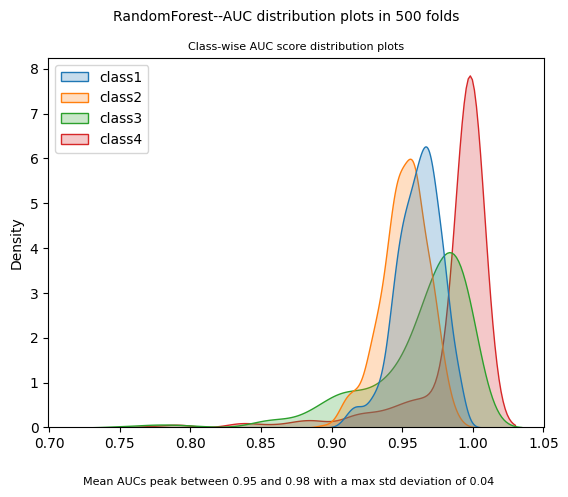

In [ ]:
# How are AUC distributed over 500 folds? (randomforest)
_=sns.kdeplot(classwise_roc, fill=True)
_=plt.suptitle("RandomForest--AUC distribution plots in 500 folds ", ha="center", fontsize=10)
_=plt.title("Class-wise AUC score distribution plots", ha="center", fontsize=8)
min = np.round(np.min(all_roc_auc_array.reshape(500,4).mean(axis=0)),2)
max = np.round(np.max(all_roc_auc_array.reshape(500,4).mean(axis=0)),2)
maxsd = np.round(np.max(all_roc_auc_array.reshape(500,4).std(axis=0)),2)
_=plt.figtext(0.5, -0.01, f"Mean AUCs peak between {min} and {max} with a max std deviation of {maxsd}",
              ha="center",
              fontsize=8)
_=plt.show()

#### Accuracy distribution (randomforest modeling)

In [ ]:
print("===randomforest=====")
acc_array['randomforest'] = np.array(total_acc_list).flatten()

===randomforest=====


In [ ]:
print("Overall Accuracy               :", np.mean(acc_array['randomforest']))
print("Median Accuracy                :", np.median(acc_array['randomforest']))
print("Std deviation of accuracy      :", np.std(acc_array['randomforest']))
print("Class-wise avg AUC score       :", all_roc_auc_array.reshape(500,4).mean(axis=0))
print("Class-wise avg std dev of AUCs :", all_roc_auc_array.reshape(500,4).std(axis=0))
print("(for classes 1,2,3,4 respectively)")
print("========")

Overall Accuracy               : 0.8816443718592964
Median Accuracy                : 0.8844221105527639
Std deviation of accuracy      : 0.023679840572769485
Class-wise avg AUC score       : [0.96129719 0.95134092 0.96064782 0.98463669]
Class-wise avg std dev of AUCs : [0.01585664 0.01660901 0.03991271 0.03447581]
(for classes 1,2,3,4 respectively)


#### Distribution plot for accuracy (randomforest)

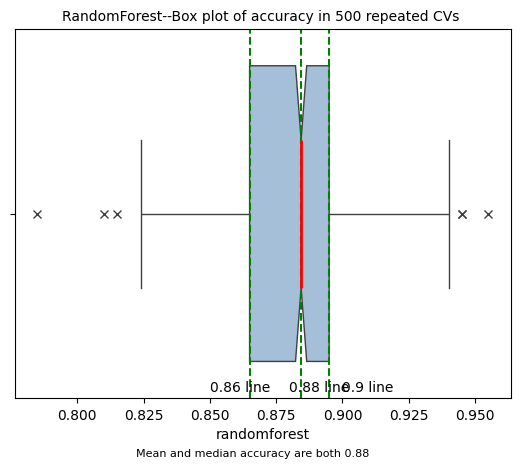

In [ ]:
# Accuracy box plot. How accuracy varies over CV trials (randomforest)
_=plt.title("RandomForest--Box plot of accuracy in 500 repeated CVs ",
            ha="center",
            fontsize=10)
ax=sns.boxplot(
            data=acc_array, x="randomforest",
            notch=True, showcaps=True,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "r", "linewidth": 2},
            )

pts = np.quantile(acc_array['randomforest'], [0.25,0.5,0.75])

_=ax.axvline(x=pts[0], color='g', linestyle='--')
_=ax.axvline(x=pts[1], color='g', linestyle='--')
_=ax.axvline(x=pts[2], color='g', linestyle='--')  # 75% obs above this line

_=ax.text(0.85,0.48, f"{np.round(pts[0],2)} line")
_=ax.text(0.88,0.48, f"{np.round(pts[1],2)} line")
_=ax.text(0.90,0.48, f"{np.round(pts[2],2)} line")

_=plt.figtext(0.5, -0.01, f"Mean and median accuracy are both {np.round(pts[1],2)} ",
              ha="center",
              fontsize=8)
_=plt.show()

#### logloss (randomForest)

In [ ]:
print("===randomforest=====")
logloss_array['randomforest'] = np.array(total_ll_list).flatten()

===randomforest=====


In [ ]:
print("Overall mean logloss          :", np.mean(logloss_array['randomforest']))
print("Median logloss                :", np.median(logloss_array['randomforest']))
print("Std deviation of logloss      :", np.std(logloss_array['randomforest']))
print("========")

Overall mean logloss          : 0.41344303759451223
Median logloss                : 0.40556332426992103
Std deviation of logloss      : 0.053742906841277326


#### precision/recall/f1 scores (randomforest modeling)

In [ ]:
# Classification scores (randomforest)
classification_scores = np.array(total_class0)
res =  [x for sublist in classification_scores for x in sublist]
classification_array['randomforest'] = res

In [ ]:
# 'Explode' the list into columns
classwise_classification_scores = classification_array['randomforest'].apply(pd.Series)

# Rename the columns
classwise_classification_scores.columns = ['precision', 'recall', 'f1-score', 'support']
print("======")
print(f"Mean classification scores\n\n{classwise_classification_scores.mean()}")
print("======")
print("")
print(f"Std Dev of classification scores\n\n{classwise_classification_scores.std()}")
print("======")


Mean classification scores

precision     0.895856
recall        0.848873
f1-score      0.870566
support      64.800000
dtype: float64

Std Dev of classification scores

precision    0.041678
recall       0.048998
f1-score     0.033132
support      0.400401
dtype: float64


#### precision/recall/f1 scores distribution plots

>The **F1 score** is a metric that evaluates a model's accuracy by combining precision and recall. It's calculated as the harmonic mean of these two values, providing a balanced view of a model's ability to correctly identify positive instances (precision) and avoid missing any positive instances (recall).

>>**Precision**: Measures the proportion of true positive predictions out of all positive predictions made by the model. It focuses on how many of the model's predictions were correct.

>>**Recall**: Measures the proportion of true positive predictions out of all actual positive instances in the dataset. It focuses on how well the model captures all the relevant positive instances.

>>**Harmonic Mean**: The F1 score uses the harmonic mean, which gives more weight to lower values of precision or recall. This means that if either precision or recall is very low, the F1 score will also be low, even if the other metric is high.

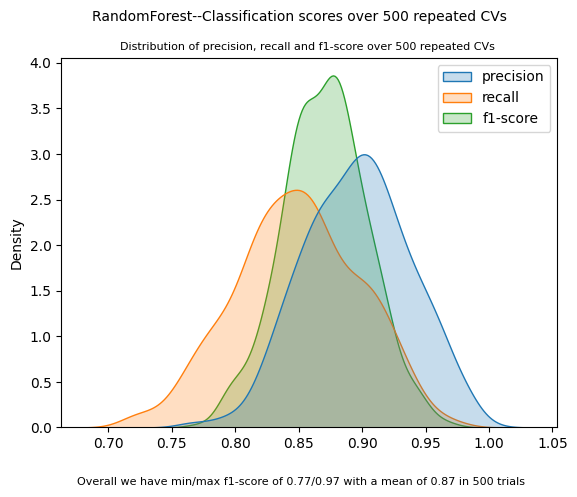

In [ ]:
# Classification score distribution plots--500 in 500 repeated CVs (randoforest)
_=sns.kdeplot(classwise_classification_scores[["precision", 	"recall", 	"f1-score"]], fill=True)
_=plt.suptitle("RandomForest--Classification scores over 500 repeated CVs ", ha="center", fontsize=10)
_=plt.title("Distribution of precision, recall and f1-score over 500 repeated CVs ", ha="center", fontsize=8)
f1_min = np.round(classwise_classification_scores['f1-score'].min(),2)
f1_max = np.round(classwise_classification_scores['f1-score'].max(),2)
f1_mean= np.round(classwise_classification_scores['f1-score'].mean(),2)
_=plt.figtext(0.5, -0.01, f"Overall we have min/max f1-score of {f1_min}/{f1_max} with a mean of {f1_mean} in 500 trials",
              ha="center",
              fontsize=8)
_=plt.show()

#### Save to gdrive

In [ ]:
acc_array.to_pickle(acc_array_path, index=False)
roc_array.to_pickle(roc_array_path, index=False)
classification_array.to_pickle(classification_array_path, index=False)
logloss_array.to_pickle(logloss_array_path, index=False)

##### Read back

In [ ]:
if os.path.exists(acc_array_path ):
    acc_array = pd.read_pickle(acc_array_path)

if os.path.exists(roc_array_path):
    roc_array = pd.read_pickle(roc_array_path)

if os.path.exists(classification_array_path):
    classification_array = pd.read_pickle(classification_array_path)

if os.path.exists(logloss_array_path):
    logloss_array = pd.read_pickle(logloss_array_path)

##### Check

In [ ]:
## Check if data retrieved
acc_array.head(2)
roc_array.head(2)
classification_array.head(2)
logloss_array.head(2)

,randomforest,histclassifier,extratrees
0,0.900,0.915,0.905
1,0.885,0.890,0.910


,randomforest,histclassifier,extratrees
0,[0.94535613 0.9434862 0.99966033 0.99925981],[0.97173789 0.95748782 0.96059783 1. ],[0.98165242 0.98001218 0.94904891 0.98593634]
1,[0.94990809 0.93714489 0.96190935 0.99703923],[0.95898438 0.93131088 0.92317583 1. ],[0.97627528 0.96661932 0.98585664 1. ]


,randomforest;histclassifier;extratrees;randomforest,randomforest
0,[ 0.9137931 0.81538462 0.86178862 65. ...,[ 0.9137931 0.81538462 0.86178862 65. ]
1,[ 0.875 0.875 0.875 64. ];[ 0.9047619 0.8...,[ 0.875 0.875 0.875 64. ]


,randomforest,histclassifier,extratrees
0,0.384078,0.475659,0.306623
1,0.414014,0.684497,0.274976


### HistGradientBoostingClassifier

>HistGradientBoostingClassifier is a fast, memory-efficient machine learning algorithm in scikit-learn for classification tasks, based on histogram-based gradient boosting decision trees. It is optimized for large datasets and uses a histogram technique to speed up training by grouping feature values into bins, which reduces computation and memory usage. This method also natively supports missing values and is generally faster and more scalable than the traditional GradientBoostingClassifier, while often achieving similar or better accuracy

#### Hyperparameter search

In [ ]:
%%time

# Hyperparameter search Takes 20minutes

hist_classifier = HistGradientBoostingClassifier(
                                                 categorical_features = cat_features,
                                                 loss = 'log_loss',
                                                 warm_start=False
                                                 )


param_grid = {
              "learning_rate": [0.01, 0.05, 0.1, 0.15],
              "min_samples_leaf": [15,20, 22,25,30],
              "max_leaf_nodes": [7, 10, 15, 20,25,30,35, 40,45],
              "l2_regularization": loguniform(1e-4, 1e-2),
              "max_features" : [0.5,0.6,0.7,0.8,0.9,1],
              "max_iter"     : [150,200,250,300,350]
             }

# Takes time
model_random_search = RandomizedSearchCV(hist_classifier,
                                         param_distributions=param_grid,
                                         n_jobs=-1,
                                         n_iter = 200, # 200 points search. Takes time
                                         cv=5          # For each point, 5-fold evaluation
                                       )


model_random_search.fit(X_train, y_train)
hist_bst_param= model_random_search.best_params_
hist_bst_param


CPU times: user 11.9 s, sys: 1.93 s, total: 13.8 s
Wall time: 18min 23s


{'l2_regularization': np.float64(0.0008765786227423513),
 'learning_rate': 0.1,
 'max_features': 0.8,
 'max_iter': 300,
 'max_leaf_nodes': 45,
 'min_samples_leaf': 15}

Best Parameters:       
"""     
{'min_samples_leaf': 15,    
 'max_leaf_nodes': 30,    
 'max_iter': 250,       
 'max_features': 0.7,      
 'learning_rate': 0.15,       
 'l2_regularization': 0.002}  

{'l2_regularization': np.float64(0.0008610172655089705),     
 'learning_rate': 0.15,      
 'max_features': 0.6,     
 'max_iter': 250,    
 'max_leaf_nodes': 35,    
 'min_samples_leaf': 20}    

{'l2_regularization': np.float64(0.0008536867093147364),    
 'learning_rate': 0.1,    
 'max_features': 0.9,    
 'max_iter': 300,    
 'max_leaf_nodes': 40,    
 'min_samples_leaf': 20}     

 {'l2_regularization': np.float64(0.0008765786227423513),     
 'learning_rate': 0.1,     
 'max_features': 0.8,     
 'max_iter': 300,    
 'max_leaf_nodes': 45,    
 'min_samples_leaf': 15}               


"""

#### Repeated StartifiedKFold

In [ ]:
# We now use the hyperparamer values:

l2_regularization = 0.0008765786227423513
learning_rate = 0.1
max_features = 0.8
max_iter = 300
max_leaf_nodes = 45
min_samples_leaf = 15

In [ ]:
%%time

import time

# Ref: https://stackoverflow.com/a/66022487

clf = HistGradientBoostingClassifier(max_iter= max_iter,
                                     max_leaf_nodes= max_leaf_nodes,
                                     min_samples_leaf = min_samples_leaf,
                                     l2_regularization = l2_regularization,
                                     categorical_features = cat_features,
                                     learning_rate = learning_rate,
                                      max_features = max_features,
                                      #class_weight = 'balanced'
                                      )


n = 100
# Store (cormack lehane) classwise classification-report
# over all n-repeated 5-fold n_splits:
total_class0 = []  # [class0] * n
total_class1 = []  # [[['precision', 'recall', 'f1-score', 'support'] * n_splits ] *n]
total_class2 = []  # [class2] * n
total_class3 = []  # [class3] * n
# To store, class-wise roc-data, for n attempts
all_roc_auc = []
# To store accuracy data for n attempts
total_acc_list = []
# To store logloss data for n attempts
total_ll_list = []
count = 1

print("==******************************************" )
print(f"Total number of folds would be: {n * 5}" )
print("==******************************************\n\n" )

# We take 5-random folds n times
for i in range(n):
  start = time.time()
  # To store accuracy data averaged over all classes
  list_accu_stratified = []
  # To store logloss
  list_ll_stratified = []
  # Class-wise roc-data for each of the classes for five folds
  list_roc_auc = []
  # Classwise classification report per cross-validation
  class0 = []  # class0: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class1 = []  # class1: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class2 = []  # class2: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class3 = []  # class3: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]

  # Get Stratified K-Fold cross-validator object
  skf = StratifiedKFold(
                        n_splits=5,
                        shuffle=True
                        )

  # Iterate 5-times ie once per split/fold
  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]  # y is label encoded
      print("=======")
      print("fold:", count ) ; count = count +1
      if (i < 1):
        print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
        print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Use X_train, X_test, y_train, y_test to train/evaluate model in each fold
      clf.fit(X_train, y_train)

      # 1. Get accuracy in this particular split (but averaged over all classes)
      acc = clf.score(X_test, y_test)
      print("Accuracy for this fold/split averaged over all the classes:", acc)
      list_accu_stratified.append(acc)

      # 2. Get class-wise AUC scores:
      # ovr==>One-vs-rest auc
      auc = roc_auc_score(y_test,
                          clf.predict_proba(X_test),
                          multi_class='ovr', # Ref: https://stackoverflow.com/a/66022487
                          average = None)

      print("Class-wise AUC for this fold/split:", auc)
      list_roc_auc.append(auc)

      # 3. Classification report: precision/f1/recall/support
      sk = classification_report(y_test,
                                 clf.predict(X_test),
                                 output_dict = True  # dict format and not tabular format
                                 )
      # sk['0'].values(): ['precision', 'recall', 'f1-score', 'support']
      #                   for class-0 of cormack lehane
      class0.append(list(sk['0'].values()))
      class1.append(list(sk['1'].values()))
      class2.append(list(sk['2'].values()))
      class3.append(list(sk['3'].values()))

      # 4.0 log_loss
      prob = clf.predict_proba(X_test)
      ll = log_loss(y_test, prob)
      print("logloss for this fold/split:", ll)
      list_ll_stratified.append(ll)

  total_acc_list.append(list_accu_stratified)
  total_ll_list.append(list_ll_stratified)
  total_class0.append(class0)
  total_class1.append(class1)
  total_class2.append(class2)
  total_class3.append(class3)
  all_roc_auc.append(list_roc_auc)
  print(f"Mean accuracy over {i+1}-n_splits of 5-folds each : {np.mean(np.array(total_acc_list).flatten())}")
  print(f"Mean logloss over {i+1}-n_splits of 5-folds each : {np.mean(np.array(total_ll_list).flatten())}")
  end = time.time()
  print(f"Time taken for 5-folds {(end-start)/60} min")

hist_classifier = clf


==******************************************
Total number of folds would be: 500
==******************************************


fold: 1
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy for this fold/split averaged over all the classes: 0.915
Class-wise AUC for this fold/split: [0.97173789 0.95748782 0.96059783 1.        ]
logloss for this fold/split: 0.4756589463304523
fold: 2
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy for this fold/split averaged over all the classes: 0.89
Class-wise AUC for this fold/split: [0.95898438 0.93131088 0.92317583 1.        ]
logloss for this fold/split: 0.6844969024898206
fold: 3
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy for this fold/split averaged over all the classes: 0.9
Class-wise AUC for this fold/split: [0.95498575 0.94918514 0.97364192 0.99703923]
logloss for this fold/split: 0.6519

In [ ]:
# Just check shapes of our metrics collectors
# n_splits: 5
# Repeated n_splits:100
# No of classes: 4
# No of classification scores: 4 (precision/recall/f1/support)

# 1. Classification reports
np.array(class0).shape                 # (5x4)       [For everyone of n_splits, one report]
np.array(total_class0).shape           # (100, 5, 4)
# 2. AUC
np.array(list_roc_auc).shape           # (5X4)       [For everyone of n_splits, AUC over all 4 classes]
np.array(all_roc_auc).shape            # (100, 5, 4)
# 3. Accuracy
np.array(list_accu_stratified).shape   # (5,)        [Mean accuracy over every one of n_splits]
np.array(total_acc_list).shape         # (100,5)
# 4. logloss
np.array(list_ll_stratified).shape     # (5,)        [Mean accuracy over every one of n_splits]
np.array(total_ll_list).shape          # (100,5)

(5, 4)

(100, 5, 4)

(5, 4)

(100, 5, 4)

(5,)

(100, 5)

(5,)

(100, 5)

#### AUC scores (histclassifier modeling)

In [ ]:
# AUC data compilation (histclassifier)
all_roc_auc_array = np.array(all_roc_auc)
all_roc_auc_array.shape
# Class-wise mean of AUCs
print("HistClassifier--Class-wise mean of AUCs    :" ,all_roc_auc_array.reshape(500,4).mean(axis=0))
# Class-wise std dev of AUCs
print("HistClassifier--Class-wise std devs of AUCs:" ,all_roc_auc_array.reshape(500,4).std(axis=0))


(100, 5, 4)

HistClassifier--Class-wise mean of AUCs    : [0.95486351 0.94559865 0.95347208 0.97711473]
HistClassifier--Class-wise std devs of AUCs: [0.01972489 0.01866784 0.04321325 0.0597457 ]


#### AUC distribution plot (HistClassifier)

In [ ]:
# Classwise AUCs in 500 iterations (histclassifier)
# Unlist the list
res =  [x for sublist in all_roc_auc for x in sublist]
# Store the resulting output in pandas Dataframe
roc_array['histclassifier'] = res

In [ ]:
# 'Explode' the list into class-wise columns
classwise_roc = roc_array['histclassifier'].apply(pd.Series)
# Rename the columns
classwise_roc.columns = ['class1', 'class2', 'class3', 'class4']
print("              Class-wise AUCs")
classwise_roc.head()

              Class-wise AUCs


,class1,class2,class3,class4
0,0.971738,0.957488,0.960598,1.000000
1,0.958984,0.931311,0.923176,1.000000
2,0.954986,0.949185,0.973642,0.997039
3,0.954765,0.941134,0.997414,0.849741
4,0.915614,0.893428,0.903685,0.665803


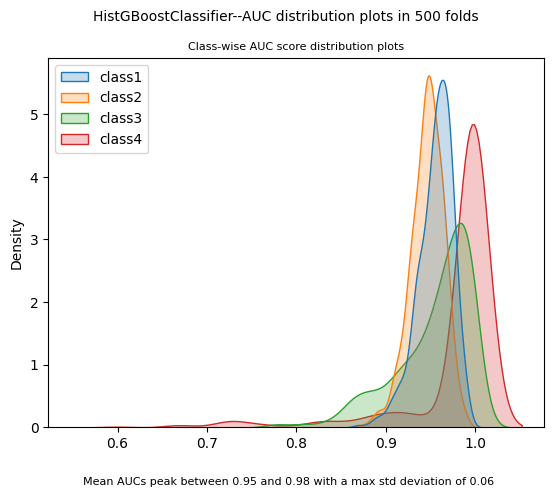

In [ ]:
# AUC distribution plots--500 folds (histclassifier)
_=sns.kdeplot(classwise_roc, fill=True)
_=plt.suptitle("HistGBoostClassifier--AUC distribution plots in 500 folds ", ha="center", fontsize=10)
_=plt.title("Class-wise AUC score distribution plots", ha="center", fontsize=8)
min = np.round(np.min(all_roc_auc_array.reshape(500,4).mean(axis=0)),2)
max = np.round(np.max(all_roc_auc_array.reshape(500,4).mean(axis=0)),2)
maxsd = np.round(np.max(all_roc_auc_array.reshape(500,4).std(axis=0)),2)
_=plt.figtext(0.5, -0.01, f"Mean AUCs peak between {min} and {max} with a max std deviation of {maxsd}",
              ha="center",
              fontsize=8)
_=plt.show()

#### Accuracy scores (histclassifier)


In [ ]:
# Mean accuracy scores over CV trials (extratrees)
print("===HistClassifier=====")
acc_array['histclassifier'] = np.array(total_acc_list).flatten()

In [ ]:
print("Mean Accuracy                  :", np.mean(acc_array['histclassifier']))
print("Median Accuracy                :", np.median(acc_array['histclassifier']))
print("Std deviation of accuracy      :", np.std(acc_array['histclassifier']))
print("Class-wise avg AUC score       :", all_roc_auc_array.reshape(500,4).mean(axis=0))
print("Class-wise avg std dev of AUCs :", all_roc_auc_array.reshape(500,4).std(axis=0))
print("(for classes 1,2,3,4 respectively)")
print("========")

===HistClassifier=====
Mean Accuracy                  : 0.8860047738693467
Median Accuracy                : 0.8894472361809045
Std deviation of accuracy      : 0.023816242353717633
Class-wise avg AUC score       : [0.95486351 0.94559865 0.95347208 0.97711473]
Class-wise avg std dev of AUCs : [0.01972489 0.01866784 0.04321325 0.0597457 ]
(for classes 1,2,3,4 respectively)


#### Distribution plot for accuracy (HistClassifier)

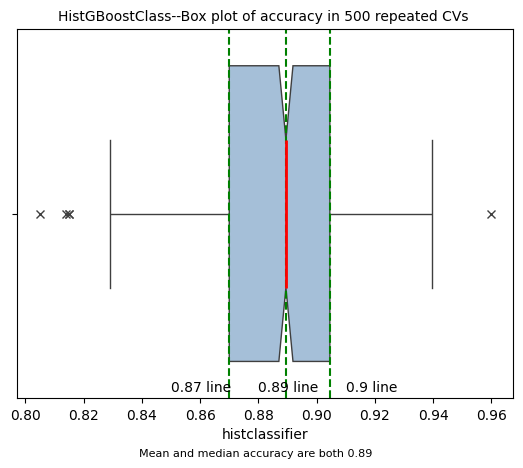

In [ ]:
# Accuracy box plot. How accuracy varies over CV trials (randomforest)
_=plt.title("HistGBoostClass--Box plot of accuracy in 500 repeated CVs ",
            ha="center",
            fontsize=10)
ax=sns.boxplot(
            data=acc_array, x="histclassifier",
            notch=True, showcaps=True,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "r", "linewidth": 2},
            )

pts = np.quantile(acc_array['histclassifier'], [0.25,0.5,0.75])

_=ax.axvline(x=pts[0], color='g', linestyle='--')
_=ax.axvline(x=pts[1], color='g', linestyle='--')
_=ax.axvline(x=pts[2], color='g', linestyle='--')  # 75% obs above this line

_=ax.text(0.85,0.48, f"{np.round(pts[0],2)} line")
_=ax.text(0.88,0.48, f"{np.round(pts[1],2)} line")
_=ax.text(0.91,0.48, f"{np.round(pts[2],2)} line")

_=plt.figtext(0.5, -0.01, f"Mean and median accuracy are both {np.round(pts[1],2)} ",
              ha="center",
              fontsize=8)
_=plt.show()

#### logloss (HistGradientBoostingClassifier)

In [ ]:
print("===histclassifier=====")
logloss_array['histclassifier'] = np.array(total_ll_list).flatten()

In [ ]:
print("Overall mean logloss          :", np.mean(logloss_array['histclassifier']))
print("Median logloss                :", np.median(logloss_array['histclassifier']))
print("Std deviation of logloss      :", np.std(logloss_array['histclassifier']))
print("========")

===histclassifier=====
Overall mean logloss          : 0.6683392709405387
Median logloss                : 0.6628884383750115
Std deviation of logloss      : 0.18899218327696699


#### precision/recall/f1 scores (HistClassifier modeling)

In [ ]:
# Classification scores (extratrees)
classification_scores = np.array(total_class0)

# Unlist the list
res =  [x for sublist in classification_scores for x in sublist]

classification_array['histclassifier'] = res

In [ ]:
# 'Explode' the list into columns
classwise_classification_scores = classification_array['histclassifier'].apply(pd.Series)

# Rename the columns
classwise_classification_scores.columns = ['precision', 'recall', 'f1-score', 'support']
print("======")
print(f"Mean classification scores\n\n{classwise_classification_scores.mean()}")
print("======")
print("")
print(f"Std Dev of classification scores\n\n{classwise_classification_scores.std()}")
print("======")


Mean classification scores

precision     0.877072
recall        0.856470
f1-score      0.865578
support      64.800000
dtype: float64

Std Dev of classification scores

precision    0.043059
recall       0.048121
f1-score     0.034550
support      0.400401
dtype: float64


#### precision/recall/f1 scores distribution plots (histclassifier)

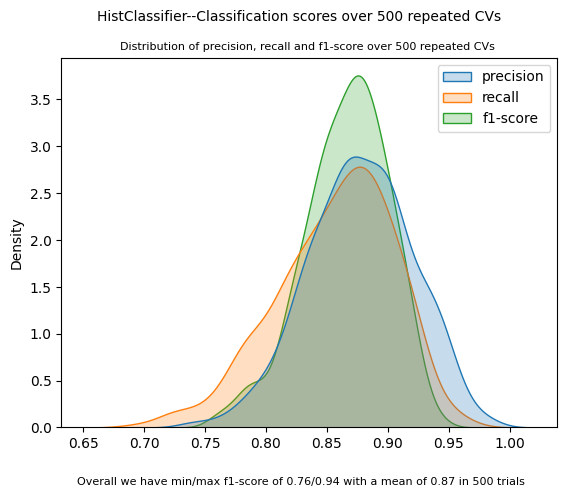

In [ ]:
# Classification score distribution plots--500 in 500 repeated CVs (randoforest)
_=sns.kdeplot(classwise_classification_scores[["precision", 	"recall", 	"f1-score"]], fill=True)
_=plt.suptitle("HistClassifier--Classification scores over 500 repeated CVs ", ha="center", fontsize=10)
_=plt.title("Distribution of precision, recall and f1-score over 500 repeated CVs ", ha="center", fontsize=8)
f1_min = np.round(classwise_classification_scores['f1-score'].min(),2)
f1_max = np.round(classwise_classification_scores['f1-score'].max(),2)
f1_mean= np.round(classwise_classification_scores['f1-score'].mean(),2)
_=plt.figtext(0.5, -0.01, f"Overall we have min/max f1-score of {f1_min}/{f1_max} with a mean of {f1_mean} in 500 trials",
              ha="center",
              fontsize=8)
_=plt.show()

#### Save to gdrive

In [ ]:
acc_array.to_pickle(acc_array_path, index=False)
roc_array.to_pickle(roc_array_path, index=False)
classification_array.to_pickle(classification_array_path, index=False)
logloss_array.to_pickle(logloss_array_path, index=False)

##### Read back

In [ ]:
if os.path.exists(acc_array_path ):
    acc_array = pd.read_pickle(acc_array_path)

if os.path.exists(roc_array_path):
    roc_array = pd.read_pickle(roc_array_path)

if os.path.exists(classification_array_path):
    classification_array = pd.read_pickle(classification_array_path)

if os.path.exists(logloss_array_path):
    logloss_array = pd.read_pickle(logloss_array_path)

##### Check

In [ ]:
## Check if data retrieved
acc_array.head(2)
roc_array.head(2)
classification_array.head(2)
logloss_array.head(2)

,randomforest,histclassifier,extratrees
0,0.90,0.915,0.905
1,0.87,0.890,0.910


,randomforest,histclassifier,extratrees
0,[0.94535613 0.9434862 0.99966033 0.99925981],[0.97173789 0.95748782 0.96059783 1. ],[0.98165242 0.98001218 0.94904891 0.98593634]
1,[0.94990809 0.93714489 0.96190935 0.99703923],[0.95898438 0.93131088 0.92317583 1. ],[0.97627528 0.96661932 0.98585664 1. ]


,randomforest,histclassifier,extratrees
0,[ 0.9375 0.92307692 0.93023256 65. ],[ 0.89393939 0.90769231 0.90076336 65. ],[ 0.90625 0.89230769 0.89922481 65. ]
1,[ 0.91071429 0.796875 0.85 64. ],[ 0.9047619 0.890625 0.8976378 64. ],[ 0.86567164 0.90625 0.88549618 64. ]


,randomforest,histclassifier,extratrees
0,0.408622,0.475659,0.306623
1,0.403991,0.684497,0.274976


### ExtraTreesClassifier

#### Repeated StartifiedKFold


In [ ]:
%%time


clf = ExtraTreesClassifier(criterion="entropy",
                           n_estimators=400,
                           max_depth=None,
                           min_samples_split=2,
                           warm_start=False
                           )

n = 100
# Store (cormack lehane) classwise classification-report
# over all n-repeated 5-fold n_splits:
total_class0 = []  # [class0] * n
total_class1 = []  # [[['precision', 'recall', 'f1-score', 'support'] * n_splits ] *n]
total_class2 = []  # [class2] * n
total_class3 = []  # [class3] * n
# To store, class-wise roc-data, for n attempts
all_roc_auc = []
# To store accuracy data for n attempts
total_acc_list = []
# To store logloss data for n attempts
total_ll_list = []
count = 1

print("==******************************************" )
print(f"Total number of folds would be: {n * 5}" )
print("==******************************************\n\n" )

# We take 5-random folds n times
for i in range(n):
  start = time.time()
  # To store accuracy data averaged over all classes
  list_accu_stratified = []
  # To store logloss
  list_ll_stratified = []
  # Class-wise roc-data for each of the classes for five folds
  list_roc_auc = []
  # Classwise classification report per cross-validation
  class0 = []  # class0: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class1 = []  # class1: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class2 = []  # class2: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class3 = []  # class3: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]

  # Get Stratified K-Fold cross-validator object
  skf = StratifiedKFold(
                        n_splits=5,
                        shuffle=True
                        )

  # Iterate 5-times ie once per split/fold
  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]  # y is label encoded
      print("=======")
      print("fold:", count ) ; count = count +1
      if (i < 1):
        print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
        print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Use X_train, X_test, y_train, y_test to train/evaluate model in each fold
      clf.fit(X_train, y_train)

      # 1. Get accuracy in this particular split (but averaged over all classes)
      acc = clf.score(X_test, y_test)
      print("Accuracy for this fold/split averaged over all the classes:", acc)
      list_accu_stratified.append(acc)

      # 2. Get class-wise AUC scores:
      # ovr==>One-vs-rest auc
      auc = roc_auc_score(y_test,
                          clf.predict_proba(X_test),
                          multi_class='ovr', # Ref: https://stackoverflow.com/a/66022487
                          average = None)

      print("Class-wise AUC for this fold/split:", auc)
      list_roc_auc.append(auc)

      # 3. Classification report: precision/f1/recall/support
      sk = classification_report(y_test,
                                 clf.predict(X_test),
                                 output_dict = True  # dict format and not tabular format
                                 )
      # sk['0'].values(): ['precision', 'recall', 'f1-score', 'support']
      #                   for class-0 of cormack lehane
      class0.append(list(sk['0'].values()))
      class1.append(list(sk['1'].values()))
      class2.append(list(sk['2'].values()))
      class3.append(list(sk['3'].values()))

      # 4.0 log_loss
      prob = clf.predict_proba(X_test)
      ll = log_loss(y_test, prob)
      print("logloss for this fold/split:", ll)
      list_ll_stratified.append(ll)

  total_acc_list.append(list_accu_stratified)
  total_ll_list.append(list_ll_stratified)
  total_class0.append(class0)
  total_class1.append(class1)
  total_class2.append(class2)
  total_class3.append(class3)
  all_roc_auc.append(list_roc_auc)
  print(f"Mean accuracy over {i+1}-n_splits of 5-folds each : {np.mean(np.array(total_acc_list).flatten())}")
  print(f"Mean logloss over {i+1}-n_splits of 5-folds each : {np.mean(np.array(total_ll_list).flatten())}")
  end = time.time()
  print(f"Time taken for 5-folds {(end-start)/60} min")

extra_classifier = clf

==******************************************
Total number of folds would be: 500
==******************************************


fold: 1
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy for this fold/split averaged over all the classes: 0.905
Class-wise AUC for this fold/split: [0.98165242 0.98001218 0.94904891 0.98593634]
logloss for this fold/split: 0.3066229051009629
fold: 2
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy for this fold/split averaged over all the classes: 0.91
Class-wise AUC for this fold/split: [0.97627528 0.96661932 0.98585664 1.        ]
logloss for this fold/split: 0.2749762345058313
fold: 3
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy for this fold/split averaged over all the classes: 0.91
Class-wise AUC for this fold/split: [0.93304843 0.93319162 1.         1.        ]
logloss for this fold/split: 0.505

In [ ]:
# Just check shapes of our metrics collectors
# n_splits: 5
# Repeated n_splits:100
# No of classes: 4
# No of classification scores: 4 (precision/recall/f1/support)

# 1. Classification reports
np.array(class0).shape                 # (5x4)       [For everyone of n_splits, one report]
np.array(total_class0).shape           # (100, 5, 4)
# 2. AUC
np.array(list_roc_auc).shape           # (5X4)       [For everyone of n_splits, AUC over all 4 classes]
np.array(all_roc_auc).shape            # (100, 5, 4)
# 3. Accuracy
np.array(list_accu_stratified).shape   # (5,)        [Mean accuracy over every one of n_splits]
np.array(total_acc_list).shape         # (100,5)
# 4. logloss
np.array(list_ll_stratified).shape     # (5,)        [Mean accuracy over every one of n_splits]
np.array(total_ll_list).shape          # (100,5)

(5, 4)

(100, 5, 4)

(5, 4)

(100, 5, 4)

(5,)

(100, 5)

(5,)

(100, 5)

#### AUC scores (ExtraTrees modeling)

In [ ]:
# AUC data compilation (extratrees)
all_roc_auc_array = np.array(all_roc_auc)
all_roc_auc_array.shape
# Class-wise mean of AUCs
print("ExtraTrees--Class-wise mean of AUCs:    " ,all_roc_auc_array.reshape(500,4).mean(axis=0))
# Class-wise std dev of AUCs
print("ExtraTrees--Class-wise std devs of AUCs:" ,all_roc_auc_array.reshape(500,4).std(axis=0))

(100, 5, 4)

ExtraTrees--Class-wise mean of AUCs:     [0.96970051 0.96217203 0.97305162 0.99061276]
ExtraTrees--Class-wise std devs of AUCs: [0.01285747 0.01253592 0.02877413 0.0217798 ]


#### AUC distribution plot (extratrees modeling)

In [ ]:
# Classwise AUCs in 500 iterations (extratrees)
# Unlist the list
res =  [x for sublist in all_roc_auc for x in sublist]
# Store the resulting output in pandas Dataframe
roc_array['extratrees'] = res

In [ ]:
# 'Explode' the list into class-wise columns
classwise_roc = roc_array['extratrees'].apply(pd.Series)
# Rename the columns
classwise_roc.columns = ['class1', 'class2', 'class3', 'class4']
print("              Class-wise AUCs")
classwise_roc.head()

              Class-wise AUCs


,class1,class2,class3,class4
0,0.981652,0.980012,0.949049,0.985936
1,0.976275,0.966619,0.985857,1.000000
2,0.933048,0.933192,1.000000,1.000000
3,0.961194,0.969953,0.954428,1.000000
4,0.969173,0.955006,0.979476,0.997409


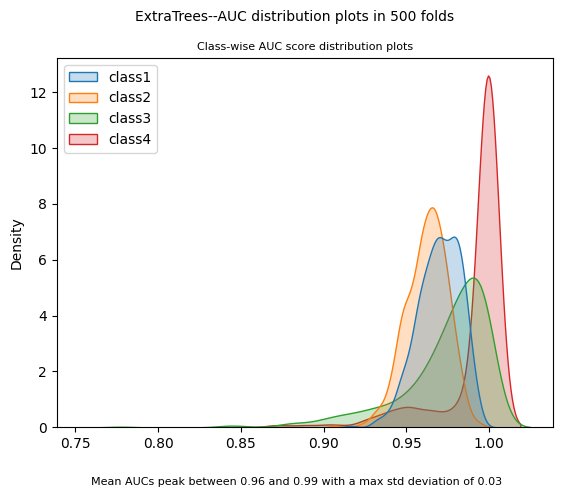

In [ ]:
# AUC distribution plots--500 folds (Extratrees)
_=sns.kdeplot(classwise_roc, fill=True)
_=plt.suptitle("ExtraTrees--AUC distribution plots in 500 folds ", ha="center", fontsize=10)
_=plt.title("Class-wise AUC score distribution plots", ha="center", fontsize=8)
min = np.round(np.min(all_roc_auc_array.reshape(500,4).mean(axis=0)),2)
max = np.round(np.max(all_roc_auc_array.reshape(500,4).mean(axis=0)),2)
maxsd = np.round(np.max(all_roc_auc_array.reshape(500,4).std(axis=0)),2)
_=plt.figtext(0.5, -0.01, f"Mean AUCs peak between {min} and {max} with a max std deviation of {maxsd}",
              ha="center",
              fontsize=8)
_=plt.show()

#### Accuracy scores (extratrees)


In [ ]:
# Mean accuracy scores over CV trials (extratrees)
print("===ExtraTrees=====")
acc_array['extratrees'] = np.array(total_acc_list).flatten()

===ExtraTrees=====


In [ ]:
print("Mean Accuracy                  :", np.mean(acc_array['extratrees']))
print("Median Accuracy                :", np.median(acc_array['extratrees']))
print("Std deviation of accuracy      :", np.std(acc_array['extratrees']))
print("Class-wise avg AUC score       :", all_roc_auc_array.reshape(500,4).mean(axis=0))
print("Class-wise avg std dev of AUCs :", all_roc_auc_array.reshape(500,4).std(axis=0))
print("(for classes 1,2,3,4 respectively)")
print("========")

Mean Accuracy                  : 0.9095085929648242
Median Accuracy                : 0.91
Std deviation of accuracy      : 0.019495123001935233
Class-wise avg AUC score       : [0.96970051 0.96217203 0.97305162 0.99061276]
Class-wise avg std dev of AUCs : [0.01285747 0.01253592 0.02877413 0.0217798 ]
(for classes 1,2,3,4 respectively)


#### Distribution plot for accuracy (ExtraTrees)


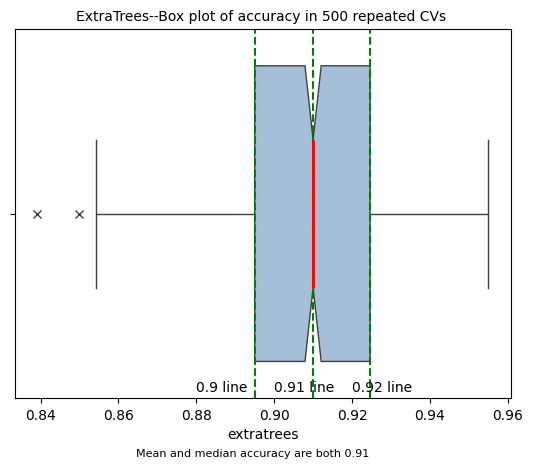

In [ ]:
# Accuracy box plot. How accuracy varies over CV trials (extratrees)
_=plt.title("ExtraTrees--Box plot of accuracy in 500 repeated CVs ", ha="center", fontsize=10)
ax=sns.boxplot(
            data=acc_array, x="extratrees",
            notch=True, showcaps=True,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "r", "linewidth": 2},
            )

pts = np.quantile(acc_array['extratrees'], [0.25,0.5,0.75])

_=ax.axvline(x=pts[0], color='g', linestyle='--')
_=ax.axvline(x=pts[1], color='g', linestyle='--')
_=ax.axvline(x=pts[2], color='g', linestyle='--')  # 75% obs above this line

_=ax.text(0.88,0.48, f"{np.round(pts[0],2)} line")
_=ax.text(0.90,0.48, f"{np.round(pts[1],2)} line")
_=ax.text(0.92,0.48, f"{np.round(pts[2],2)} line")

_=plt.figtext(0.5, -0.01, f"Mean and median accuracy are both {np.round(pts[1],2)} ",
              ha="center",
              fontsize=8)
_=plt.show()

#### logloss (ExtraTrees Classifier)

In [ ]:
print("===extratrees=====")
logloss_array['extratrees'] = np.array(total_ll_list).flatten()

===extratrees=====


In [ ]:
print("Overall mean logloss          :", np.mean(logloss_array['extratrees']))
print("Median logloss                :", np.median(logloss_array['extratrees']))
print("Std deviation of logloss      :", np.std(logloss_array['extratrees']))
print("========")

Overall mean logloss          : 0.411824235690332
Median logloss                : 0.423874257744855
Std deviation of logloss      : 0.13641046870995013


#### precision/recall/f1 scores (ExtraTrees modeling)

In [ ]:
# Classification scores (extratrees)
classification_scores = np.array(total_class0)

# Unlist the list
res =  [x for sublist in classification_scores for x in sublist]
classification_array['extratrees'] = res

In [ ]:
# 'Explode' the list into columns
classwise_classification_scores = classification_array['extratrees'].apply(pd.Series)

# Rename the columns
classwise_classification_scores.columns = ['precision', 'recall', 'f1-score', 'support']
print("======")
print(f"Mean classification scores\n\n{classwise_classification_scores.mean()}")
print("======")
print("")
print(f"Std Dev of classification scores\n\n{classwise_classification_scores.std()}")
print("======")


Mean classification scores

precision     0.901905
recall        0.891095
f1-score      0.895446
support      64.800000
dtype: float64

Std Dev of classification scores

precision    0.038245
recall       0.042292
f1-score     0.026996
support      0.400401
dtype: float64


#### precision/recall/f1 scores distribution plots (extratrees)

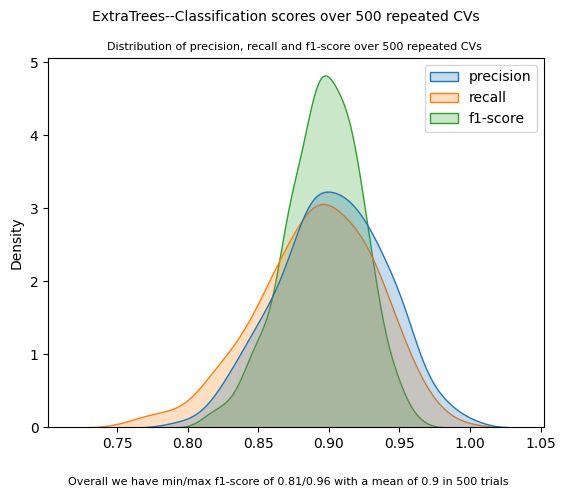

In [ ]:
# Classification score distribution plots--500 in 500 repeated CVs (extratrees))
_=sns.kdeplot(classwise_classification_scores[["precision", 	"recall", 	"f1-score"]], fill=True)
_=plt.suptitle("ExtraTrees--Classification scores over 500 repeated CVs ", ha="center", fontsize=10)
_=plt.title("Distribution of precision, recall and f1-score over 500 repeated CVs ", ha="center", fontsize=8)
f1_min = np.round(classwise_classification_scores['f1-score'].min(),2)
f1_max = np.round(classwise_classification_scores['f1-score'].max(),2)
f1_mean= np.round(classwise_classification_scores['f1-score'].mean(),2)
_=plt.figtext(0.5, -0.01, f"Overall we have min/max f1-score of {f1_min}/{f1_max} with a mean of {f1_mean} in 500 trials",
              ha="center",
              fontsize=8)
_=plt.show()

#### Permutation feature importance
Refer [here](https://scikit-learn.org/stable/modules/permutation_importance.html) AND [here](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

>Permutation feature importance is a model-agnostic technique used to assess the contribution of individual features to a machine learning model's predictive performance. It works with any supervised learning algorithm. It measures how much a model's performance degrades when a specific feature's values are randomly shuffled, breaking its relationship with the target variable. A larger performance drop indicates higher importance for that feature. BAsic steps are:


>>1. Train the model and evaluate its baseline performance (e.g., accuracy, RMSE) on a held-out dataset.
>>2. Shuffle one feature while keeping others unchanged, then recompute performance.
>>3. Compare performance between the original and shuffled scenarios to calculate importance.
4. Repeat for all features and multiple permutations to reduce variance.

Its one limitation is that it importance scores reflect a specific model-dataset pairing, not intrinsic feature value.


In [ ]:
# Splitting the dataset into test & train
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    stratify=y)

# Our Extratrees model
clf = ExtraTreesClassifier(criterion="entropy",
                           n_estimators=400,
                           max_depth=None,
                           min_samples_split=2,
                           warm_start=False
                           )
clf.fit(X_train, y_train)

# Calculate permutation importance with test data
# We permute each feature 40 times
etr = permutation_importance(clf,
                             X_test, y_test,
                             n_repeats=40  # Permute 40 times each feature
                             )




ExtraTreesClassifier(criterion='entropy', n_estimators=400)

In [ ]:
# Importance collectors
# Feature names
cols = []
# Feature impt
etr_mean = []
# Feature impt std dev
etr_std = []

print("Extent of degradation of accuracy score")
print("=======================================\n")
for i in etr.importances_mean.argsort()[::-1]:
    if etr.importances_mean[i] - 2 * etr.importances_std[i] > 0:
        print(f"{df.columns[i]:<13}\t\t\t"
              f"{etr.importances_mean[i]:.3f}"
              f" +/- {etr.importances_std[i]:.3f}")
        cols.append(df.columns[i])
        etr_mean.append(np.round(etr.importances_mean[i],2))
        etr_std.append(np.round(etr.importances_std[i],2))
print("===============")

Extent of degradation of accuracy score

mallampatti  			0.189 +/- 0.022
sex          			0.117 +/- 0.015
age          			0.099 +/- 0.018
bmi          			0.091 +/- 0.016
buck teeth   			0.078 +/- 0.016
thyromental distance			0.069 +/- 0.010
edentulous   			0.058 +/- 0.013
height       			0.045 +/- 0.011
head and neck movement			0.045 +/- 0.011
sternomental distance			0.039 +/- 0.010
subluxation of mandible			0.035 +/- 0.010
mouth opening			0.005 +/- 0.001


In [ ]:
# Tabulate above results
# Ref: https://pypi.org/project/tabulate/
from tabulate import tabulate
table = [cols, etr_mean, etr_std]
print("                                                       Extent of degradation of accuracy score")
print(tabulate(table, showindex = ["cols=>", "mean", "std"], tablefmt = 'grid'))

                                                       Extent of degradation of accuracy score
+--------+-------------+------+------+------+------------+----------------------+------------+--------+------------------------+-----------------------+-------------------------+---------------+
| cols=> | mallampatti | sex  | age  | bmi  | buck teeth | thyromental distance | edentulous | height | head and neck movement | sternomental distance | subluxation of mandible | mouth opening |
+--------+-------------+------+------+------+------------+----------------------+------------+--------+------------------------+-----------------------+-------------------------+---------------+
| mean   | 0.19        | 0.12 | 0.1  | 0.09 | 0.08       | 0.07                 | 0.06       | 0.04   | 0.04                   | 0.04                  | 0.03                    | 0.01          |
+--------+-------------+------+------+------+------------+----------------------+------------+--------+----------------------

##### Plot feature importancw

In [ ]:
# Plot function for permutation importance
# Ref: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

def plot_permutation_importance(etr, X, y, ax):
    perm_sorted_idx = etr.importances_mean.argsort()
    tick_labels_dict = {"tick_labels": X.columns[perm_sorted_idx]}
    ax.boxplot(etr.importances[perm_sorted_idx].T, vert=False, **tick_labels_dict)
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

<Axes: >

<Axes: >

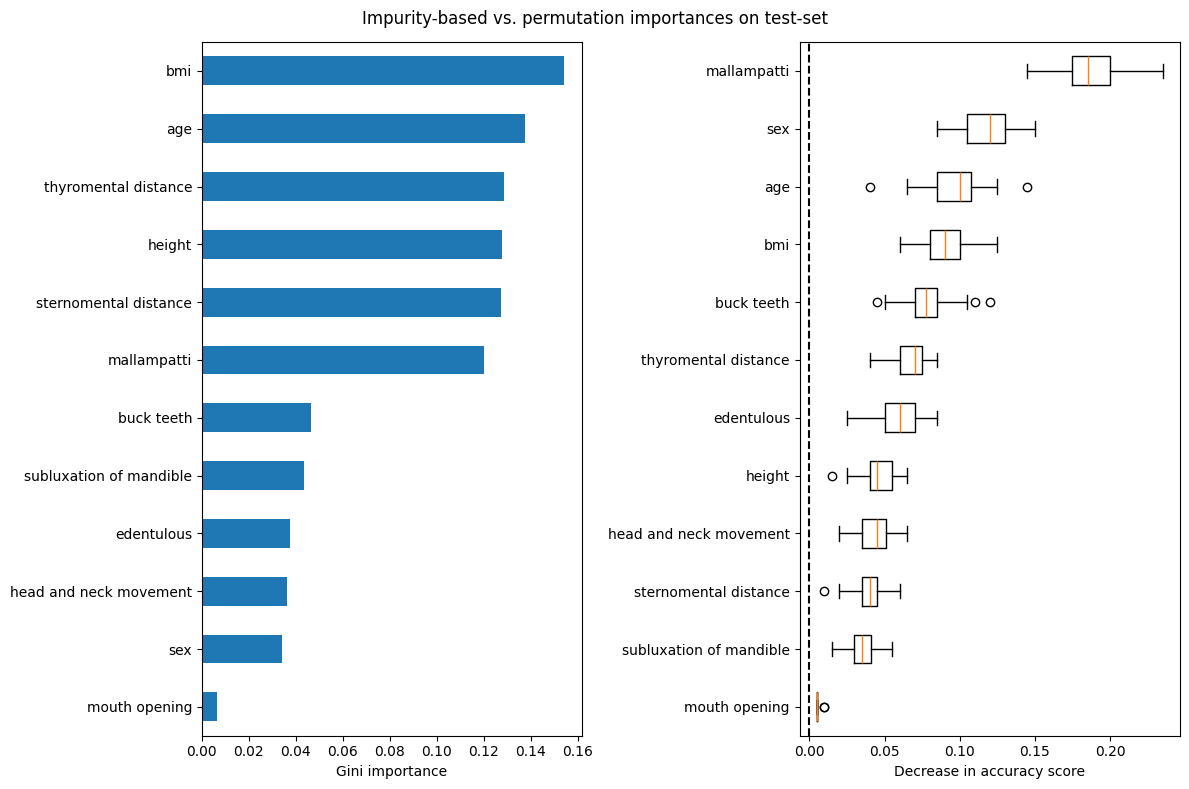

In [ ]:
# Plot impurity based and permutaion based importances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Impurity based importance plot
mdi_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
mdi_importances.sort_values().plot.barh(ax=ax1)
_=ax1.set_xlabel("Gini importance")

# Permutation importance plot
plot_permutation_importance(etr, X_test, y_test, ax2)
_=ax2.set_xlabel("Decrease in accuracy score")

_=fig.suptitle(
    "Impurity-based vs. permutation importances on test-set"
)
_ = fig.tight_layout()

#### Save to gdrive

In [ ]:
acc_array.to_pickle(acc_array_path, index=False)
roc_array.to_pickle(roc_array_path, index=False)
classification_array.to_pickle(classification_array_path, index=False)
logloss_array.to_pickle(logloss_array_path, index=False)

##### Read back

In [ ]:
if os.path.exists(acc_array_path ):
    acc_array = pd.read_pickle(acc_array_path)

if os.path.exists(roc_array_path):
    roc_array = pd.read_pickle(roc_array_path)

if os.path.exists(classification_array_path):
    classification_array = pd.read_pickle(classification_array_path)

if os.path.exists(logloss_array_path):
    logloss_array = pd.read_pickle(logloss_array_path)

##### Check

In [ ]:
## Check if data retrieved
acc_array.head(2)
roc_array.head(2)
classification_array.head(2)
logloss_array.head(2)

,randomforest,histclassifier,extratrees
0,0.90,0.915,0.905
1,0.87,0.890,0.910


,randomforest,histclassifier,extratrees
0,[0.98108262 0.96423498 0.93834918 1. ],[0.97173789 0.95748782 0.96059783 1. ],[0.98165242 0.98001218 0.94904891 0.98593634]
1,[0.97449449 0.96601055 0.95178399 1. ],[0.95898438 0.93131088 0.92317583 1. ],[0.97627528 0.96661932 0.98585664 1. ]


,randomforest,histclassifier,extratrees
0,[ 0.9375 0.92307692 0.93023256 65. ],[ 0.89393939 0.90769231 0.90076336 65. ],[ 0.90625 0.89230769 0.89922481 65. ]
1,[ 0.91071429 0.796875 0.85 64. ],[ 0.9047619 0.890625 0.8976378 64. ],[ 0.86567164 0.90625 0.88549618 64. ]


,randomforest,histclassifier,extratrees
0,0.408622,0.475659,0.306623
1,0.403991,0.684497,0.274976


### XGBoost classifier

#### Hyperparameter search

In [ ]:
%%time

# Took 30 minutes
# Search for the best xgboost parameters using Randomized cv search

xgb_classifier = XGBClassifier(
                                objective='binary:logistic',
                                eval_metric = accuracy_score,
                                n_jobs = 16
                               )

# Consider these parameters:
param_grid = {
              "booster" : ['gbtree', 'dart', 'gblinear'],
              "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
              "n_estimators" : [200, 250,300,350],
              "max_depth" : [3,4,5,6,7,8,9],
              "grow_policy" : ['depthwise', 'lossguide'],
              "colsample_bytree" : [0.5,0.7,0.9,1.0],
              "reg_lambda": loguniform(1e-4, 1e-2),
              "reg_alpha" : loguniform(1e-4, 1e-2),
              "gamma" : loguniform(1e-4, 1e-2),
             }

# Evaluate over 100 points in the search space
# Best fitted model is returned
model_random_search = RandomizedSearchCV(xgb_classifier,
                                         param_distributions=param_grid,
                                         n_jobs=-1,
                                         n_iter = 100,  # Look at 100 pts
                                         cv=5,
                                         verbose=1   # Show progress
                                        )


model_random_search.fit(X_train, y_train)
xgb_bst_param= model_random_search.best_params_
xgb_bst_param

CPU times: user 1min 43s, sys: 5.6 s, total: 1min 49s
Wall time: 1h 19min 9s


{'booster': 'dart',
 'colsample_bytree': 0.9,
 'gamma': np.float64(0.003954038661298285),
 'grow_policy': 'depthwise',
 'learning_rate': 0.05,
 'max_depth': 7,
 'n_estimators': 300,
 'reg_alpha': np.float64(0.0004317759184976679),
 'reg_lambda': np.float64(0.0016423427819499588)}

#### Best fitted model's performance

In [ ]:
# Best fitted model's performance:

# 1. Accuracy
print(f"1. Accuracy {model_random_search.score(X_test,y_test)}")  # 0.8592964824120602


# 2. Class-wise AUC
print(f"2. class-wise AUC {roc_auc_score(y_test, model_random_search.predict_proba(X_test), multi_class='ovr', average = None)}")

# 3. logloss
print(f"3. Logloss: {log_loss(y_test, model_random_search.predict_proba(X_test))}")


# 4. Classificatio reports
print(f"4. Classification report\n: {classification_report(y_test,model_random_search.predict(X_test))}")





1. Accuracy 0.9798994974874372
2. class-wise AUC [0.99862227 0.9987715  0.99806076 1.        ]
3. Logloss: 0.08743477435569968
4. Classification report
:               precision    recall  f1-score   support

           0       1.00      0.97      0.98        65
           1       0.97      1.00      0.98       111
           2       1.00      0.88      0.94        17
           3       1.00      1.00      1.00         6

    accuracy                           0.98       199
   macro avg       0.99      0.96      0.98       199
weighted avg       0.98      0.98      0.98       199



Here are the hyperparameter values:     
"""       
CPU times: user 48.8 s, sys: 3.93 s, total: 52.7 s     
Wall time: 42min 7s     

{'booster': 'dart',     
 'colsample_bytree': 0.5,     
 'gamma': np.float64(0.0034610752394487725),    
 'grow_policy': 'depthwise',      
 'learning_rate': 0.2,     
 'max_depth': 8,          
 'n_estimators': 200,        
 'reg_alpha': np.float64(0.0003584127720728602),       
 'reg_lambda': np.float64(0.002922484172354949)}       


booster = 'dart',    
colsample_bytree =  0.5,    
gamma = np.float64(0.0034610752394487725),    
grow_policy = 'depthwise',    
learning_rate = 0.2,   
max_depth = 8,   
n_estimators = 200,   
reg_alpha = np.float64(0.0003584127720728602),  
reg_lambda = np.float64(0.002922484172354949)   

{'booster': 'dart',      
 'colsample_bytree': 0.9,        
 'gamma': np.float64(0.003954038661298285),       
 'grow_policy': 'depthwise',         
 'learning_rate': 0.05,      
 'max_depth': 7,       
 'n_estimators': 300,        
 'reg_alpha': np.float64(0.0004317759184976679),      
 'reg_lambda': np.float64(0.0016423427819499588)}          


"""

#### Repeated StratifiedKFold

In [ ]:
# From hyperparameter search:

booster =  'dart'
colsample_bytree = 0.9
gamma = 0.003954038661298285
grow_policy = 'depthwise'
learning_rate = 0.05
max_depth = 7
n_estimators = 300
reg_alpha = 0.0004317759184976679
reg_lambda = 0.0016423427819499588

In [ ]:
%%time

import time

clf = XGBClassifier(booster = booster,
                        max_depth = max_depth,
                        n_estimators=n_estimators,
                        grow_policy = grow_policy,
                        colsample_bytree = colsample_bytree,
                        reg_lambda = reg_lambda,
                        reg_alpha = reg_alpha,
                        gamma = gamma,
                        learning_rate = learning_rate,
                        objective='binary:logistic',
                        n_jobs = -1
                        )


n = 3
# Store (cormack lehane) classwise classification-report
# over all n-repeated 5-fold n_splits:
total_class0 = []  # [class0] * n
total_class1 = []  # [[['precision', 'recall', 'f1-score', 'support'] * n_splits ] *n]
total_class2 = []  # [class2] * n
total_class3 = []  # [class3] * n
# To store, class-wise roc-data, for n attempts
all_roc_auc = []
# To store accuracy data for n attempts
total_acc_list = []
# To store logloss data for n attempts
total_ll_list = []
count = 1

print("==******************************************" )
print(f"Total number of folds would be: {n * 5}" )
print("==******************************************\n\n" )

# We take 5-random folds n times
for i in range(n):
  start = time.time()
  # To store accuracy data averaged over all classes
  list_accu_stratified = []
  # To store logloss
  list_ll_stratified = []
  # Class-wise roc-data for each of the classes for five folds
  list_roc_auc = []
  # Classwise classification report per cross-validation
  class0 = []  # class0: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class1 = []  # class1: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class2 = []  # class2: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class3 = []  # class3: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]

  # Get Stratified K-Fold cross-validator object
  skf = StratifiedKFold(
                        n_splits=5,
                        shuffle=True
                        )

  # Iterate 5-times ie once per split/fold
  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]  # y is label encoded
      print("=======")
      print("fold:", count ) ; count = count +1
      if (i < 1):
        print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
        print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Use X_train, X_test, y_train, y_test to train/evaluate model in each fold
      clf.fit(X_train, y_train)

      # 1. Get accuracy in this particular split (but averaged over all classes)
      acc = clf.score(X_test, y_test)
      print("Accuracy for this fold/split averaged over all the classes:", acc)
      list_accu_stratified.append(acc)

      # 2. Get class-wise AUC scores:
      # ovr==>One-vs-rest auc
      auc = roc_auc_score(y_test,
                          clf.predict_proba(X_test),
                          multi_class='ovr', # Ref: https://stackoverflow.com/a/66022487
                          average = None)

      print("Class-wise AUC for this fold/split:", auc)
      list_roc_auc.append(auc)

      # 3. Classification report: precision/f1/recall/support
      sk = classification_report(y_test,
                                 clf.predict(X_test),
                                 output_dict = True  # dict format and not tabular format
                                 )
      # sk['0'].values(): ['precision', 'recall', 'f1-score', 'support']
      #                   for class-0 of cormack lehane
      class0.append(list(sk['0'].values()))
      class1.append(list(sk['1'].values()))
      class2.append(list(sk['2'].values()))
      class3.append(list(sk['3'].values()))

      # 4.0 log_loss
      prob = clf.predict_proba(X_test)
      ll = log_loss(y_test, prob)
      print("logloss for this fold/split:", ll)
      list_ll_stratified.append(ll)

  total_acc_list.append(list_accu_stratified)
  total_ll_list.append(list_ll_stratified)
  total_class0.append(class0)
  total_class1.append(class1)
  total_class2.append(class2)
  total_class3.append(class3)
  all_roc_auc.append(list_roc_auc)
  print(f"Mean accuracy over {i+1}-n_splits of 5-folds each : {np.mean(np.array(total_acc_list).flatten())}")
  print(f"Mean logloss over {i+1}-n_splits of 5-folds each : {np.mean(np.array(total_ll_list).flatten())}")
  end = time.time()
  print(f"Time taken for five folds: {(end-start)/60} min")

xgb_classifier = clf


==******************************************
Total number of folds would be: 15
==******************************************


fold: 1
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy for this fold/split averaged over all the classes: 0.88
Class-wise AUC for this fold/split: [0.9639886  0.95211039 0.92493207 0.98741673]
logloss for this fold/split: 0.37536652364177614
fold: 2
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy for this fold/split averaged over all the classes: 0.89
Class-wise AUC for this fold/split: [0.92061121 0.93374594 0.92446159 0.99925981]
logloss for this fold/split: 0.4326703842801136
fold: 3
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy for this fold/split averaged over all the classes: 0.89
Class-wise AUC for this fold/split: [0.97863248 0.92281607 0.84924462 0.98593634]
logloss for this fold/split: 0.4442

In [ ]:
# Just check shapes of our metrics collectors
# n_splits: 5
# Repeated n_splits: n
# No of classes: 4
# No of classification scores: 4 (precision/recall/f1/support)

# 1. Classification reports
np.array(class0).shape                 # (5x4)       [For everyone of n_splits, one report]
np.array(total_class0).shape           # (n, 5, 4)
# 2. AUC
np.array(list_roc_auc).shape           # (5X4)       [For everyone of n_splits, AUC over all 4 classes]
np.array(all_roc_auc).shape            # (n, 5, 4)
# 3. Accuracy
np.array(list_accu_stratified).shape   # (5,)        [Mean accuracy over every one of n_splits]
np.array(total_acc_list).shape         # (n,5)
# 4. logloss
np.array(list_ll_stratified).shape     # (5,)        [Mean accuracy over every one of n_splits]
np.array(total_ll_list).shape          # (n,5)

(5, 4)

(3, 5, 4)

(5, 4)

(3, 5, 4)

(5,)

(3, 5)

(5,)

(3, 5)

#### AUC scores (xgbclf)

In [ ]:
# AUC data compilation (xgbclassifier)
all_roc_auc_array = np.array(all_roc_auc)
all_roc_auc_array.shape
# Class-wise mean of AUCs
print("XGb Classifier--Class-wise mean of AUCs:    " ,all_roc_auc_array.reshape(n*5,4).mean(axis=0))
# Class-wise std dev of AUCs
print("XGb Classifier--Class-wise std devs of AUCs:" ,all_roc_auc_array.reshape(n*5,4).std(axis=0))

(3, 5, 4)

XGb Classifier--Class-wise mean of AUCs:     [0.94680368 0.93500709 0.93938969 0.99036927]
XGb Classifier--Class-wise std devs of AUCs: [0.02243337 0.01657431 0.04500409 0.01037654]


#### AUC distribution (xgbclf)

In [ ]:
# Classwise AUCs in nX5 iterations (xgbclassifier)
# Unlist the list
res =  [x for sublist in all_roc_auc for x in sublist]
# Store the resulting output in pandas Dataframe
roc_array['xgbclf'] = pd.Series(res)

In [ ]:
# 'Explode' the list into class-wise columns
classwise_roc = roc_array['xgbclf'].apply(pd.Series)
# Rename the columns
classwise_roc.columns = ['class1', 'class2', 'class3', 'class4']
print("              Class-wise AUCs")
classwise_roc.head()

              Class-wise AUCs


,class1,class2,class3,class4
0,0.963989,0.952110,0.924932,0.987417
1,0.920611,0.933746,0.924462,0.999260
2,0.978632,0.922816,0.849245,0.985936
3,0.954535,0.931204,0.920168,0.992228
4,0.920551,0.902539,0.961538,0.993092


#### Accuracy scores (xgbclassifier)

In [ ]:
# Mean accuracy scores over CV trials (xgbclassifier)
print("===XGBoost Classifier=====")
acc_array['xgbclf'] = pd.Series(np.array(total_acc_list).flatten())

In [ ]:
print("Mean Accuracy                  :", np.mean(acc_array['xgbclf']))
print("Median Accuracy                :", np.nanmedian(acc_array['xgbclf']))
print("Std deviation of accuracy      :", np.std(acc_array['xgbclf']))
print("Class-wise avg AUC score       :", all_roc_auc_array.reshape(n * 5,4).mean(axis=0))
print("Class-wise avg std dev of AUCs :", all_roc_auc_array.reshape(n * 5,4).std(axis=0))
print("(for classes 1,2,3,4 respectively)")
print("========")

===XGBoost Classifier=====
Mean Accuracy                  : 0.873390284757119
Median Accuracy                : 0.875
Std deviation of accuracy      : 0.02376894420401498
Class-wise avg AUC score       : [0.94680368 0.93500709 0.93938969 0.99036927]
Class-wise avg std dev of AUCs : [0.02243337 0.01657431 0.04500409 0.01037654]
(for classes 1,2,3,4 respectively)


#### Distribution plot of accuracy (xgboost classifier)

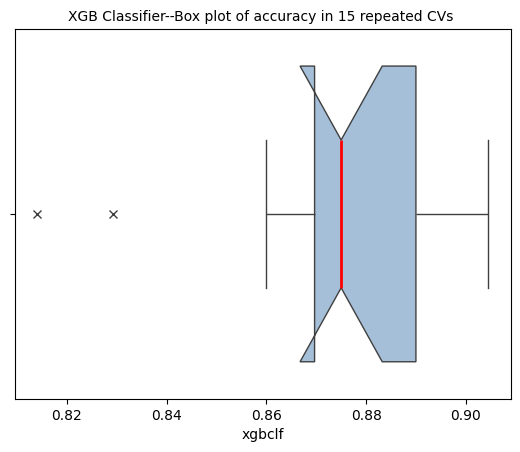

In [ ]:
# Accuracy box plot. How accuracy varies over CV trials (xgbclassifier)
_=plt.title(f"XGB Classifier--Box plot of accuracy in {n * 5} repeated CVs ",
            ha="center",
            fontsize=10)

ax=sns.boxplot(
            data=acc_array, x="xgbclf",
            notch=True, showcaps=True,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "r", "linewidth": 2},
            )


#### logloss (XGB Classifier)

In [ ]:
print("===xgbclassifier=====")
logloss_array['xgbclf'] = pd.Series(np.array(total_ll_list).flatten())

In [ ]:
print("Overall mean logloss          :", np.mean(logloss_array['xgbclf']))
print("Median logloss                :", np.nanmedian(logloss_array['xgbclf']))
print("Std deviation of logloss      :", np.std(logloss_array['xgbclf']))
print("========")

===xgbclassifier=====
Overall mean logloss          : 0.4062721487830712
Median logloss                : 0.41917178963491086
Std deviation of logloss      : 0.059767746354856


#### precision/recall/f1 scores (XGBClassifier)

In [ ]:
# Classification scores (xgbclassifier)
classification_scores = np.array(total_class0)

# Unlist the list
res =  [x for sublist in classification_scores for x in sublist]
classification_array['xgbclf'] = pd.Series(res)

In [ ]:
# 'Explode' the list into columns
classwise_classification_scores = classification_array['xgbclf'].apply(pd.Series)

# Rename the columns
classwise_classification_scores.columns = ['precision', 'recall', 'f1-score', 'support']
print("======")
print(f"Mean classification scores\n\n{classwise_classification_scores.mean()}")
print("======")
print("")
print(f"Std Dev of classification scores\n\n{classwise_classification_scores.std()}")
print("======")


Mean classification scores

precision     0.875641
recall        0.840417
f1-score      0.855681
support      64.800000
dtype: float64

Std Dev of classification scores

precision    0.048707
recall       0.066359
f1-score     0.043312
support      0.414039
dtype: float64


#### precision/recall/f1 scores distribution plots (xgbclassifier)

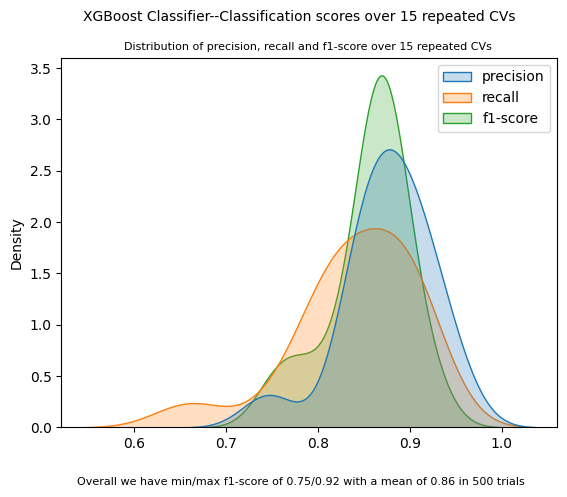

In [ ]:
# Classification score distribution plots--500 in 500 repeated CVs (xgbclassifier)
_=sns.kdeplot(classwise_classification_scores[["precision", 	"recall", 	"f1-score"]], fill=True)
_=plt.suptitle(f"XGBoost Classifier--Classification scores over {n * 5} repeated CVs ", ha="center", fontsize=10)
_=plt.title(f"Distribution of precision, recall and f1-score over {n * 5} repeated CVs ", ha="center", fontsize=8)
f1_min = np.round(classwise_classification_scores['f1-score'].min(),2)
f1_max = np.round(classwise_classification_scores['f1-score'].max(),2)
f1_mean= np.round(classwise_classification_scores['f1-score'].mean(),2)
_=plt.figtext(0.5, -0.01, f"Overall we have min/max f1-score of {f1_min}/{f1_max} with a mean of {f1_mean} in 500 trials",
              ha="center",
              fontsize=8)
_=plt.show()

#### Save to gdrive

In [ ]:
acc_array.to_pickle(acc_array_path, index=False)
roc_array.to_pickle(roc_array_path, index=False)
classification_array.to_pickle(classification_array_path, index=False)
logloss_array.to_pickle(logloss_array_path, index=False)

##### Read back

In [ ]:
if os.path.exists(acc_array_path ):
    acc_array = pd.read_pickle(acc_array_path)

if os.path.exists(roc_array_path):
    roc_array = pd.read_pickle(roc_array_path)

if os.path.exists(classification_array_path):
    classification_array = pd.read_pickle(classification_array_path)

if os.path.exists(logloss_array_path):
    logloss_array = pd.read_pickle(logloss_array_path)

##### Check

In [ ]:
## Check if data retrieved
acc_array.head(2)
roc_array.head(2)
classification_array.head(2)
logloss_array.head(2)

## Quick summary





### Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


### Read back saved data

In [ ]:
acc_array = pd.read_pickle('/gdrive/MyDrive/airways/acc_array.pkl')
roc_array = pd.read_pickle('/gdrive/MyDrive/airways/roc_array.pkl')
classification_array = pd.read_pickle('/gdrive/MyDrive/airways/classification_array.pkl')
logloss_array = pd.read_pickle('/gdrive/MyDrive/airways/logloss_array.pkl')

##### Check

In [ ]:
## Check if data retrieved
acc_array.head(2)
roc_array.head(2)
classification_array.head(2)
logloss_array.head(2)

,randomforest,histclassifier,extratrees
0,0.90,0.915,0.905
1,0.87,0.890,0.910


,randomforest,histclassifier,extratrees
0,[0.98108262 0.96423498 0.93834918 1. ],[0.97173789 0.95748782 0.96059783 1. ],[0.98165242 0.98001218 0.94904891 0.98593634]
1,[0.97449449 0.96601055 0.95178399 1. ],[0.95898438 0.93131088 0.92317583 1. ],[0.97627528 0.96661932 0.98585664 1. ]


,randomforest,histclassifier,extratrees
0,[ 0.9375 0.92307692 0.93023256 65. ],[ 0.89393939 0.90769231 0.90076336 65. ],[ 0.90625 0.89230769 0.89922481 65. ]
1,[ 0.91071429 0.796875 0.85 64. ],[ 0.9047619 0.890625 0.8976378 64. ],[ 0.86567164 0.90625 0.88549618 64. ]


,randomforest,histclassifier,extratrees
0,0.408622,0.475659,0.306623
1,0.403991,0.684497,0.274976


In [ ]:
mean = acc_array.mean()
median = acc_array.median()
stddevmean = acc_array.std()
loglossmean = logloss_array.mean()
stddevlogloass = logloss_array.std()
metrics  = pd.DataFrame({'Mean accuracy' : np.array(mean),
                         'Median accuracy' : np.array(median),
                         'stdDev mean' : acc_array.std(),
                         'Mean logloss' : logloss_array.mean(),
                         'stdDev logloss' : logloss_array.std()
                         })
metrics = metrics.T
metrics.columns = ['Random Forest','HistGradientBoost','ExtraTrees']
metrics.head()


,Random Forest,HistGradientBoost,ExtraTrees
Mean accuracy,0.882268,0.886005,0.909509
Median accuracy,0.884422,0.889447,0.910000
stdDev mean,0.023531,0.023840,0.019515
Mean logloss,0.416755,0.668339,0.411824
stdDev logloss,0.076211,0.189181,0.136547


## ======== END ================

## Rough Work
Below is rough work of algorithms that have been tried. Can be ignored.

### Repeated StratifiedKFold
But with [catboost encoder](https://contrib.scikit-learn.org/category_encoders/catboost.html) and alse see [here](https://contrib.scikit-learn.org/category_encoders/index.html)

In [ ]:
!pip install category_encoders -q

In [ ]:
%%time
import category_encoders as ce
clf = ExtraTreesClassifier(criterion = "log_loss",
                           n_estimators=400,
                           max_depth=None,
                           min_samples_split=2,
                           #class_weight = 'balanced',
                           #ccp_alpha = 0.0005
                           )

total_class0 = []
total_class1 = []
total_class2 = []
total_class3 = []
all_roc_auc  = []
total_acc_list = []
count = 1
for i in range(100):
  list_accu_stratified = []
  list_roc_auc = []
  class0  = []    # [['precision', 'recall', 'f1-score', 'support'] ....]
  class1 = []
  class2 = []
  class3 = []
  skf = StratifiedKFold(n_splits=5,
                        shuffle=True,
                        random_state = None
                        )
  #count = 1
  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]   # y is label encoded
      encoder = ce.CatBoostEncoder(cols=["sex", "edentulous",
                                         "mouth opening", "head and neck movement"]
                                   )
      encoder.fit(X_train, y_train)
      X_train = encoder.transform(X_train)
      X_test = encoder.transform(X_test)
      print("=======")
      print("fold:", count ) ; count = count +1
      print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
      print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Now you can use X_train, X_test, y_train, y_test for training and evaluating your model in each fold
      clf.fit(X_train, y_train)
      acc = clf.score(X_test, y_test)
      print("Accuracy:", acc)
      list_accu_stratified.append(acc)
      auc = roc_auc_score(y_test,
                          clf.predict_proba(X_test),
                          multi_class='ovr',
                          average = None)
      print("Class-wise AUC:", auc)
      list_roc_auc.append(auc) # One-vs-rest auc
      sk = classification_report(y_test, clf.predict(X_test), output_dict = True)
      class0.append(list(sk['0'].values()))  # [['precision', 'recall', 'f1-score', 'support']...]
      class1.append(list(sk['1'].values()))
      class2.append(list(sk['2'].values()))
      class3.append(list(sk['3'].values()))

  total_acc_list.append(list_accu_stratified)
  total_class0.append(class0)
  total_class1.append(class1)
  total_class2.append(class2)
  total_class3.append(class3)
  all_roc_auc.append(list_roc_auc)


fold: 1
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.88
Class-wise AUC: [0.96934473 0.96377841 0.99490489 0.99851962]
fold: 2
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.9
Class-wise AUC: [0.96065028 0.95058847 0.97332048 0.99851962]
fold: 3
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.92
Class-wise AUC: [0.96364672 0.96522927 0.99614272 1.        ]
fold: 4
X_train shape: (799, 12) y_train shape: (799,)
X_test shape: (199, 12) y_test shape: (199,)
Accuracy: 0.9095477386934674
Class-wise AUC: [0.96515499 0.95679771 0.99450549 1.        ]
fold: 5
X_train shape: (799, 12) y_train shape: (799,)
X_test shape: (199, 12) y_test shape: (199,)
Accuracy: 0.9547738693467337
Class-wise AUC: [0.97726751 0.97292179 0.98691015 1.        ]
fold: 6
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test sh

In [ ]:
# AUC data compilation (extratrees_catboost_enc)
all_roc_auc_array = np.array(all_roc_auc)
all_roc_auc_array.shape
# Class-wise mean of AUCs
print("ExtraTrees-catencoded--Class-wise mean of AUCs:" ,all_roc_auc_array.mean(axis=0).mean(axis=0))

(100, 5, 4)

Class-wise mean of AUCs: [0.96894044 0.96209302 0.97599309 0.98861535]


In [ ]:
# Classwise AUCs in 500 iterations (extratrees_catboost_enc)
# Unlist the list
res =  [x for sublist in all_roc_auc for x in sublist]
# Store the resulting output in pandas Dataframe
roc_array['extratrees_catboost_enc'] = res
# 'Explode' the list into class-wise columns
classwise_roc = roc_array['extratrees_catboost_enc'].apply(pd.Series)
# Rename the columns
classwise_roc.columns = ['class1', 'class2', 'class3', 'class4']
classwise_roc.head()

,class1,class2,class3,class4
0,0.969345,0.963778,0.994905,0.99852
1,0.960650,0.950588,0.973320,0.99852
2,0.963647,0.965229,0.996143,1.00000
3,0.965155,0.956798,0.994505,1.00000
4,0.977268,0.972922,0.986910,1.00000


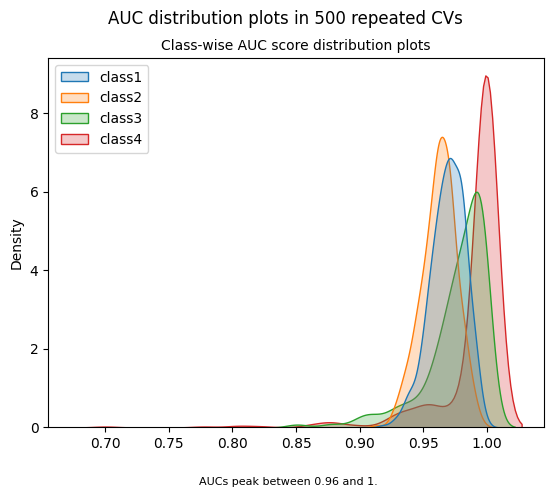

In [ ]:
# AUC distribution plots--500 in 500 repeated CVs (extratrees_catboost_enc)
_=sns.kdeplot(classwise_roc, fill=True)
_=plt.suptitle("ExtraTrees-catencoded--AUC distribution plots in 500 repeated CVs ", ha="center", fontsize=10)
_=plt.title("Class-wise AUC score distribution plots", ha="center", fontsize=8)
_=plt.figtext(0.5, -0.01, "AUCs peak between 0.96 and 1.",
              ha="center",
              fontsize=8)
_=plt.show()

In [ ]:
# Mean accuracy scores over CV trials (extratrees_catboost_enc)
print("===ExtraTrees-catencoded--=====")
acc_array['extratrees_catboost_enc'] = np.array(total_acc_list).flatten()
print("Mean Accuracy:", np.mean(acc_array['extratrees_catboost_enc']))
print("Median Accuracy:", np.median(acc_array['extratrees_catboost_enc']))
print("Std deviation of accuracy:", np.std(acc_array['extratrees_catboost_enc']))
print("Class-wise avg AUC scores :", all_roc_auc_array.mean(axis=0).mean(axis=0))
print("(for classes 1,2,3,4 respectively)")
print("========")

Mean Accuracy: 0.9101030150753768
Median Accuracy: 0.91
Std deviation of accuracy: 0.022623969202489443
Class-wise avg AUC scores : [0.96894044 0.96209302 0.97599309 0.98861535]
(for classes 1,2,3,4 respectively)


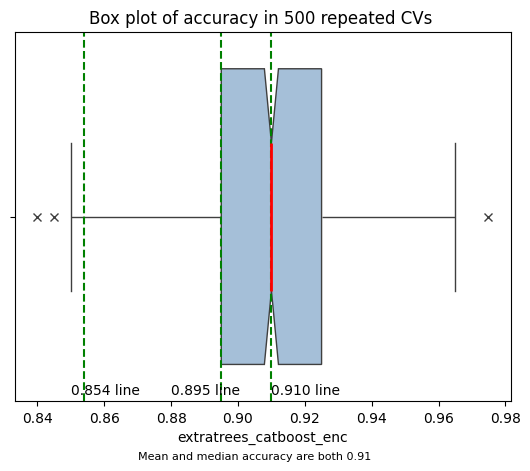

In [ ]:
# Accuracy box plot. How accuracy varies over CV trials (extratrees_catboost_enc)
_=plt.title("ExtraTrees-catencoded--Box plot of accuracy in 500 repeated CVs ", ha="center", fontsize=10)
ax=sns.boxplot(
            data=acc_array, x="extratrees_catboost_enc",
            notch=True, showcaps=True,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "r", "linewidth": 2},
            )


_=ax.axvline(x=0.854, color='g', linestyle='--')
_=ax.axvline(x=0.91, color='g', linestyle='--')
_=ax.axvline(x=0.895, color='g', linestyle='--')  # 75% obs above this line
_=ax.text(0.88,0.48, "0.895 line")
_=ax.text(0.91,0.48, "0.910 line")
_=ax.text(0.85,0.48, "0.854 line")

_=plt.figtext(0.5, -0.01, "Mean and median accuracy are both 0.91",
              ha="center",
              fontsize=8)
_=plt.show()

In [ ]:
# AUC data compilation (extratrees_catboost_enc)
classification_scores = np.array(total_class0)
# Classwise AUCs in 500 iterations
# Unlist the list
res =  [x for sublist in classification_scores for x in sublist]
# Store the resulting output in pandas Dataframe
classification_array=pd.DataFrame()
classification_array['extraTrees_catboost_enc'] = res
# 'Explode' the list into class-wise columns
classwise_classification_scores = classification_array['extraTrees_catboost_enc'].apply(pd.Series)
# Rename the columns
classwise_classification_scores.columns = ['precision', 'recall', 'f1-score', 'support']
classwise_classification_scores.head(2)


,precision,recall,f1-score,support
0,0.910714,0.784615,0.842975,65.0
1,0.878788,0.906250,0.892308,64.0


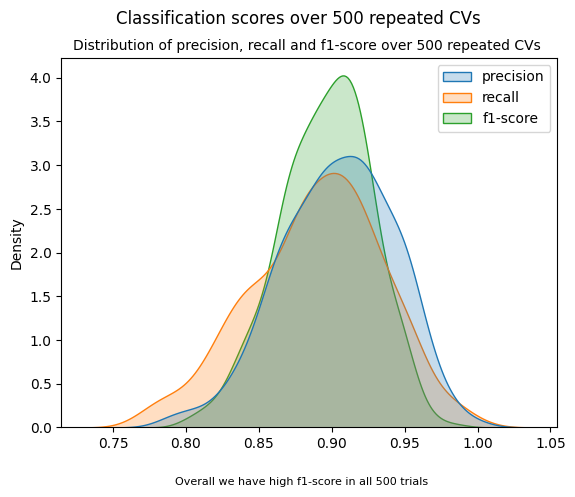

In [ ]:
# AUC distribution plots--500 in 500 repeated CVs (extratrees_catboost_enc)
_=sns.kdeplot(classwise_classification_scores[["precision", 	"recall", 	"f1-score"]], fill=True)
_=plt.suptitle("ExtraTrees-catencoded--Classification scores over 500 repeated CVs ", ha="center", fontsize=10)
_=plt.title("Distribution of precision, recall and f1-score over 500 repeated CVs ", ha="center", fontsize=8)
_=plt.figtext(0.5, -0.01, "Overall we have high f1-score in all 500 trials",
              ha="center",
              fontsize=8)
_=plt.show()

## Comparing two models
 Box plots of accuracy distributions for ExtraTrees vs ExtraTrees-catencoded

In [ ]:
# Prepare dataframes for plotting
df_melted = pd.melt(acc_array[
                               ['extratrees',
                               'extratrees_catboost_enc']
                              ],
                     var_name='Feature',
                     value_name='Value'
                     )
df_melted.head(2)
df_melted.tail(2)

,Feature,Value
0,extratrees,0.90
1,extratrees,0.92


,Feature,Value
998,extratrees_catboost_enc,0.914573
999,extratrees_catboost_enc,0.934673


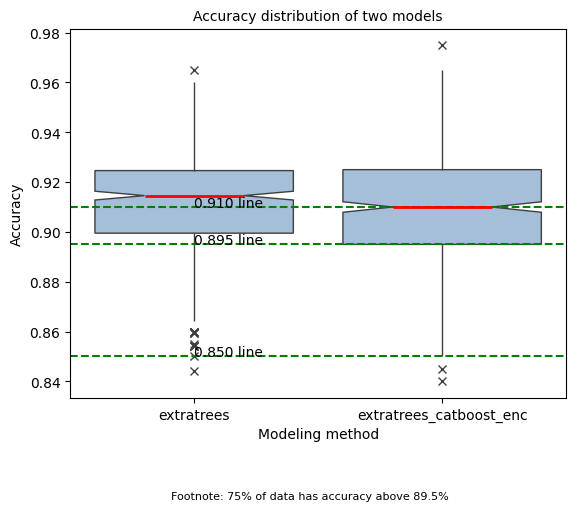

In [ ]:
# Create the boxplots
ax=sns.boxplot(
            data=df_melted, x="Feature",
            y = "Value",
            notch=True, showcaps=False,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "r", "linewidth": 2},
            )
_=ax.set(xlabel='Modeling method', ylabel='Accuracy')
_=ax.axhline(y=0.85, color='g', linestyle='--')
_=ax.axhline(y=0.91, color='g', linestyle='--')
_=ax.axhline(y=0.895, color='g', linestyle='--')  # 75% obs above this line
_=ax.text(0.0,0.895, "0.895 line")
_=ax.text(0.0,0.850, "0.850 line")
_=ax.text(0.0,0.910, "0.910 line")
_=plt.title("Accuracy distribution of two models", ha="center", fontsize=10)
_=plt.figtext(0.5, -0.1, "Footnote: 75% of data has accuracy above 89.5%", ha="center", fontsize=8)
plt.show()

### Density plots of accuracy

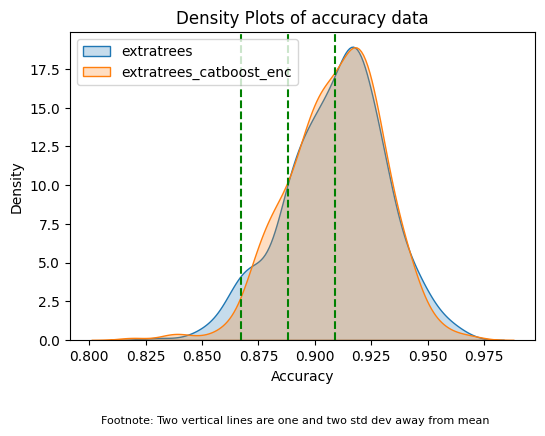

In [ ]:
# Choose the features you want to plot
features = ['extratrees', 'extratrees_catboost_enc']

_=plt.figure(figsize=(6,4))
for feature in features:
    _=sns.kdeplot(acc_array[feature], fill=True, label=feature)

_=plt.title('ExtraTrees vs ExtraTrees-catencoded--Density Plots of accuracy data',fontsize =10 )
_=plt.xlabel('Accuracy')
_=plt.ylabel('Density')
std = np.std(acc_array["extratrees_catboost_enc"])
mean = np.mean(acc_array["extratrees_catboost_enc"])
_=plt.axvline(x= mean - std * 1, color='g', linestyle='--')
_=plt.axvline(x= mean - std * 2, color='g', linestyle='--')
_=plt.axvline(x= mean , color='g', linestyle='--')
_=plt.figtext(0.5, -0.1, "Footnote: Two vertical lines are one and two std dev away from mean",
              ha="center",
              fontsize=8)

_=plt.legend()
_=plt.show()

## Voting classifier

In [ ]:
%%time

from sklearn.ensemble import  VotingClassifier



xgb_clf = XGBClassifier(booster = xgb_bst_param['booster'],
                        max_depth = xgb_bst_param['max_depth'],
                        n_estimators=200,
                        grow_policy = xgb_bst_param['grow_policy'],
                        colsample_bytree = xgb_bst_param['colsample_bytree'],
                        reg_lambda = xgb_bst_param['reg_lambda'],
                        reg_alpha = xgb_bst_param['reg_alpha'],
                        gamma =xgb_bst_param['gamma'],
                        learning_rate= xgb_bst_param['learning_rate'],
                        objective='binary:logistic',
                        #enable_categorical = True
                        )

extra_clf = ExtraTreesClassifier(n_estimators=550,
                           max_depth=None,
                           min_samples_split=2,
                           )

hist_classifier  = HistGradientBoostingClassifier(max_iter=400,
                                                 max_leaf_nodes=  hist_bst_param['max_leaf_nodes'],
                                                 l2_regularization = hist_bst_param['l2_regularization'],
                                                 categorical_features = cat_features,
                                                 learning_rate = hist_bst_param['learning_rate'],
                                                 max_features = hist_bst_param['max_features'],
                                                 #class_weight = 'balanced'
                                                 )

#rf_classifier = RandomForestClassifier(n_estimators=400)


eclf = VotingClassifier(estimators=[
                                    ('hist', hist_classifier),
                                    ('extra', extra_clf),
                                    #('rf', rf_classifier)
                                    ],
                         voting='soft')



total_acc_list = []
total_class0  = []
total_class1 = []
total_class2 = []
total_class3 = []
count = 1
for i in range(50):
  print("=========")
  print("ITERATION", i)
  print("=========")

  list_accu_stratified = []
  class0  = []    # [['precision', 'recall', 'f1-score', 'support'] ....]
  class1 = []
  class2 = []
  class3 = []
  skf = StratifiedKFold(n_splits=5,
                        shuffle=True)

  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]
      print("=======")
      print("fold:", count ) ; count = count +1
      print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
      print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Now you can use X_train, X_test, y_train, y_test for training and evaluating your model in each fold
      eclf.fit(X_train, y_train)
      print("Accuracy:", eclf.score(X_test, y_test))
      list_accu_stratified.append(eclf.score(X_test, y_test))
      sk = classification_report(y_test, eclf.predict(X_test), output_dict = True)
      class0.append(list(sk['0'].values()))  # [['precision', 'recall', 'f1-score', 'support']...]
      class1.append(list(sk['1'].values()))
      class2.append(list(sk['2'].values()))
      class3.append(list(sk['3'].values()))

  total_acc_list.append(list_accu_stratified)
  total_class0.append(class0)
  total_class1.append(class1)
  total_class2.append(class2)
  total_class3.append(class3)



ITERATION 0
fold: 1
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.89
fold: 2
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.875
fold: 3
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.9
fold: 4
X_train shape: (799, 12) y_train shape: (799,)
X_test shape: (199, 12) y_test shape: (199,)
Accuracy: 0.914572864321608
fold: 5
X_train shape: (799, 12) y_train shape: (799,)
X_test shape: (199, 12) y_test shape: (199,)
Accuracy: 0.9246231155778895
ITERATION 1
fold: 6
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.91
fold: 7
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.875
fold: 8
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.86
fold: 9
X_train shape: (799,

In [ ]:
print("========")
acc_array = np.array(total_acc_list)
acc_array.shape  # (50,5)
print("Overall Accuracy:", np.mean(acc_array))
print("Median Accuracy:", np.median(acc_array))
print("Std deviation of accuracy:", np.std(acc_array))
print("========")

(50, 5)

Overall Accuracy: 0.895751055276382
Median Accuracy: 0.895
Std deviation of accuracy: 0.023006834126292453


<Axes: xlabel='accuracy'>

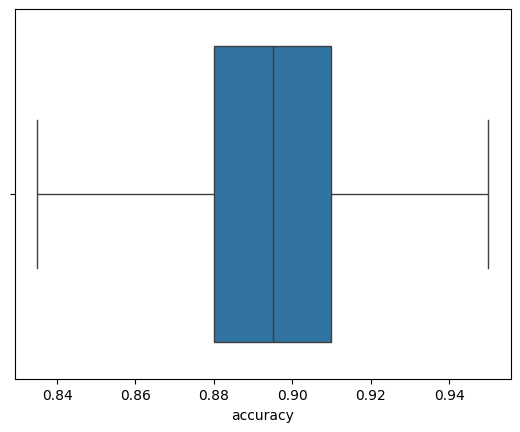

In [ ]:
acc = pd.DataFrame(acc_array.flatten(), columns = ["accuracy"])
sns.boxplot(data=acc, x="accuracy")


<Axes: xlabel='accuracy', ylabel='Density'>

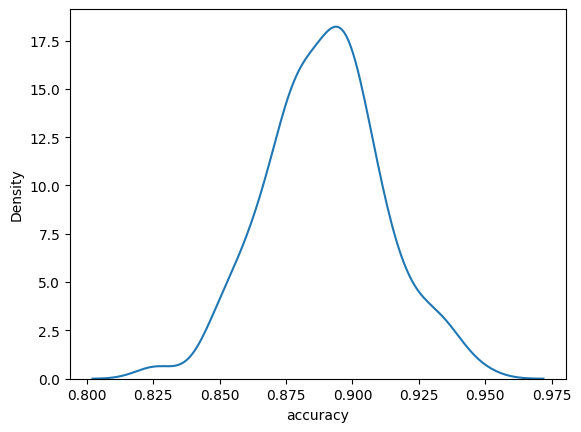

In [ ]:
sns.kdeplot(data=acc, x="accuracy")

## Stacking Classifier

In [ ]:
booster = 'dart',
colsample_bytree =  0.5,
gamma = np.float64(0.0034610752394487725),
grow_policy = 'depthwise',
learning_rate = 0.2,
max_depth = 8,
n_estimators = 200,
reg_alpha = np.float64(0.0003584127720728602),
reg_lambda = np.float64(0.002922484172354949)

# hist
l2_regularization= np.float64(0.0008536867093147364),
learning_rate=  0.1,
max_features = 0.9,
max_iter = 300,
max_leaf_nodes = 40,
min_samples_leaf = 20

In [ ]:
%%time


xgb_clf = XGBClassifier(booster = 'dart',
                        colsample_bytree =  0.5,
                        gamma = np.float64(0.0034610752394487725),
                        grow_policy = 'depthwise',
                        learning_rate = 0.2,
                        max_depth = 8,
                        n_estimators = 200,
                        reg_alpha = np.float64(0.0003584127720728602),
                        reg_lambda = np.float64(0.002922484172354949),
                        objective='binary:logistic',
                        )


extra_clf = ExtraTreesClassifier(criterion = 'entropy',n_estimators=150,
                           max_depth=None,
                           min_samples_split=2,
                           )


hist_classifier = HistGradientBoostingClassifier(l2_regularization= np.float64(0.0008536867093147364),
                                                  learning_rate=  0.1,
                                                  max_features = 0.9,
                                                  max_iter = 300,
                                                  max_leaf_nodes = 40,
                                                  min_samples_leaf = 20
                                                 )


extra_clf1 = ExtraTreesClassifier(n_estimators=350,
                                  max_depth=None,
                                  min_samples_split=2,
                                  )


sclf = StackingClassifier(estimators=[('xgb', xgb_clf),
                                      ('hist', hist_classifier),
                                       ('extra', extra_clf)],
                         final_estimator= extra_clf1,
                         n_jobs = -1,
                         passthrough = True,
                         cv = 5,
                         stack_method = 'predict_proba')

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
sclf.fit(X_train, y_train)

print(classification_report(y_test,
                      sclf.predict(X_test),
                      output_dict = True
                      ))

print("Accuracy:", sclf.score(X_test, y_test))


{'0': {'precision': 0.8780487804878049, 'recall': 0.935064935064935, 'f1-score': 0.9056603773584906, 'support': 77.0}, '1': {'precision': 0.8904109589041096, 'recall': 0.9285714285714286, 'f1-score': 0.9090909090909091, 'support': 140.0}, '2': {'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8, 'support': 24.0}, '3': {'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8, 'support': 9.0}, 'accuracy': 0.896, 'macro avg': {'precision': 0.9421149348479786, 'recall': 0.7992424242424242, 'f1-score': 0.8536878216123498, 'support': 250.0}, 'weighted avg': {'precision': 0.9010691613765452, 'recall': 0.896, 'f1-score': 0.8936343053173241, 'support': 250.0}}
Accuracy: 0.896
CPU times: user 2.18 s, sys: 287 ms, total: 2.47 s
Wall time: 34.3 s


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
neigh.score(X_test, y_test)

0.712

In [ ]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=3,
                                                       weights = 'distance',
                                                       p=1
                                                       ),
                        n_estimators=100,max_features= 0.9,bootstrap_features=False
                        ).fit(X_train, y_train)


clf.score(X_test, y_test)

0.852

In [ ]:
%%time

from sklearn.ensemble import BaggingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.gaussian_process.kernels import RBF
kernel = 1.0 * RBF(1.0)
clf = BaggingClassifier(estimator= GaussianProcessClassifier(kernel=kernel,n_jobs = -1),
                        n_estimators=10,n_jobs=-1
                        ).fit(X_train, y_train)


clf.score(X_test, y_test)

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(150, 150,150))


clf.fit(X_train, y_train)
clf.score(X_test, y_test)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(150, 150, 150), solver='lbfgs')

0.64

In [ ]:
xgb_clf = XGBClassifier(booster = 'dart',
                        colsample_bytree =  0.5,
                        gamma = np.float64(0.0034610752394487725),
                        grow_policy = 'depthwise',
                        learning_rate = 0.2,
                        max_depth = 8,
                        n_estimators = 200,
                        reg_alpha = np.float64(0.0003584127720728602),
                        reg_lambda = np.float64(0.002922484172354949),
                        objective='binary:logistic',
                        )


extra_clf = ExtraTreesClassifier(criterion = 'entropy',n_estimators=150,
                           max_depth=None,
                           min_samples_split=2,
                           )


hist_classifier = HistGradientBoostingClassifier(l2_regularization= np.float64(0.0008536867093147364),
                                                  learning_rate=  0.1,
                                                  max_features = 0.9,
                                                  max_iter = 300,
                                                  max_leaf_nodes = 40,
                                                  min_samples_leaf = 20
                                                 )


extra_clf1 = ExtraTreesClassifier(n_estimators=350,
                                  max_depth=None,
                                  min_samples_split=2,
                                  )

bag_clf = BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=3,
                                                       weights = 'distance',
                                                       p=1,
                                                       ),
                        n_estimators=10,
                        )


sclf = StackingClassifier(estimators=[('xgb', xgb_clf),
                                      ('hist', hist_classifier),
                                       ('extra', extra_clf),('bagging', bag_clf)
                                      ],
                         final_estimator= extra_clf1,
                         n_jobs = -1,
                         passthrough = True,
                         cv = 5,
                         stack_method = 'predict_proba')

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
sclf.fit(X_train, y_train)

print(classification_report(y_test,
                      sclf.predict(X_test),
                      output_dict = True
                      ))

print("Accuracy:", sclf.score(X_test, y_test))

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster='dart',
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.5, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              gamma=np.float64(0.0034610752394487725),
                                              grow_policy='depthwise',
                                              importance_type=N...
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('extra',
                                ExtraTreesClassifier(criterion='entropy',
                                                     n_estimators=150)),
                               ('bagging',
                                BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=3,
                                                                                 p=1,
                                                                                 weights='distance')))],
                   final_estimator=ExtraTreesClassifier(n_estimators=350),
                   n_jobs=-1, passthrough=True, stack_method='predict_proba')

{'0': {'precision': 0.8690476190476191, 'recall': 0.948051948051948, 'f1-score': 0.906832298136646, 'support': 77.0}, '1': {'precision': 0.9027777777777778, 'recall': 0.9285714285714286, 'f1-score': 0.9154929577464789, 'support': 140.0}, '2': {'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8, 'support': 24.0}, '3': {'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8, 'support': 9.0}, 'accuracy': 0.9, 'macro avg': {'precision': 0.9429563492063492, 'recall': 0.8024891774891775, 'f1-score': 0.8555813139707813, 'support': 250.0}, 'weighted avg': {'precision': 0.9052222222222222, 'recall': 0.9, 'f1-score': 0.8975804041641152, 'support': 250.0}}
Accuracy: 0.9


In [ ]:
from sklearn.ensemble import  VotingClassifier



xgb_clf = XGBClassifier(booster = 'dart',
                        colsample_bytree =  0.5,
                        gamma = np.float64(0.0034610752394487725),
                        grow_policy = 'depthwise',
                        learning_rate = 0.2,
                        max_depth = 8,
                        n_estimators = 200,
                        reg_alpha = np.float64(0.0003584127720728602),
                        reg_lambda = np.float64(0.002922484172354949),
                        objective='binary:logistic',
                        )


extra_clf = ExtraTreesClassifier(criterion = 'entropy',n_estimators=150,
                           max_depth=None,
                           min_samples_split=2,
                           )


hist_classifier = HistGradientBoostingClassifier(l2_regularization= np.float64(0.0008536867093147364),
                                                  learning_rate=  0.1,
                                                  max_features = 0.9,
                                                  max_iter = 300,
                                                  max_leaf_nodes = 40,
                                                  min_samples_leaf = 20
                                                 )

#rf_classifier = RandomForestClassifier(n_estimators=400)


eclf = VotingClassifier(estimators=[
                                    ('hist', hist_classifier),
                                    ('extra', extra_clf),
                                    ('xgb', xgb_clf)
                                    ],
                         voting='soft')



total_acc_list = []
total_class0  = []
total_class1 = []
total_class2 = []
total_class3 = []
count = 1
for i in range(50):
  print("=========")
  print("ITERATION", i)
  print("=========")

  list_accu_stratified = []
  class0  = []    # [['precision', 'recall', 'f1-score', 'support'] ....]
  class1 = []
  class2 = []
  class3 = []
  skf = StratifiedKFold(n_splits=5,
                        shuffle=True)

  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]
      print("=======")
      print("fold:", count ) ; count = count +1
      print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
      print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Now you can use X_train, X_test, y_train, y_test for training and evaluating your model in each fold
      eclf.fit(X_train, y_train)
      print("Accuracy:", eclf.score(X_test, y_test))
      list_accu_stratified.append(eclf.score(X_test, y_test))
      sk = classification_report(y_test, eclf.predict(X_test), output_dict = True)
      class0.append(list(sk['0'].values()))  # [['precision', 'recall', 'f1-score', 'support']...]
      class1.append(list(sk['1'].values()))
      class2.append(list(sk['2'].values()))
      class3.append(list(sk['3'].values()))

  total_acc_list.append(list_accu_stratified)
  total_class0.append(class0)
  total_class1.append(class1)
  total_class2.append(class2)
  total_class3.append(class3)

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
xgb_clf = XGBClassifier(booster = 'dart',
                        colsample_bytree =  0.5,
                        gamma = np.float64(0.0034610752394487725),
                        grow_policy = 'depthwise',
                        learning_rate = 0.2,
                        max_depth = 8,
                        n_estimators = 200,
                        reg_alpha = np.float64(0.0003584127720728602),
                        reg_lambda = np.float64(0.002922484172354949),
                        objective='binary:logistic',
                        )


extra_clf = ExtraTreesClassifier(criterion = 'entropy',
                                 n_estimators=350,
                                 max_depth=None,
                                 min_samples_split=2,
                                 )


hist_classifier = HistGradientBoostingClassifier(l2_regularization= np.float64(0.0008536867093147364),
                                                  learning_rate=  0.1,
                                                  max_features = 0.9,
                                                  max_iter = 300,
                                                  max_leaf_nodes = 40,
                                                  min_samples_leaf = 20
                                                 )



eclf = VotingClassifier(estimators=[
                                    ('hist', hist_classifier),
                                    ('extra', extra_clf),
                                    ('xgb', xgb_clf)
                                    ],
                         voting='soft')

# Define the parameter grid for weights
params = {'weights': [[0.5,1,0.5],
                      [0.7,1,0.7],
                       [0.9,1,0.9]]}

# Use GridSearchCV to find the best weights
grid = GridSearchCV(estimator=eclf,
                          param_grid=params,
                          cv=5, n_jobs = -1)
# Fit the grid search to your data (X, y)
grid.fit(X_train, y_train)
# Print the best weights and score
print("Best weights:", grid.best_params_)
print("Best score:", grid.best_score_)



Best weights: {'weights': [0.5, 1, 0.5]}
Best score: 0.925829145728643
CPU times: user 10min 24s, sys: 4.41 s, total: 10min 28s
Wall time: 7min 36s


In [ ]:
%%time
import statistics
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
xgb_clf = XGBClassifier(booster = 'dart',
                        colsample_bytree =  0.5,
                        gamma = np.float64(0.0034610752394487725),
                        grow_policy = 'depthwise',
                        learning_rate = 0.2,
                        max_depth = 8,
                        n_estimators = 200,
                        reg_alpha = np.float64(0.0003584127720728602),
                        reg_lambda = np.float64(0.002922484172354949),
                        objective='binary:logistic',
                        )


extra_clf = ExtraTreesClassifier(criterion = 'entropy',
                                 n_estimators=350,
                                 max_depth=None,
                                 min_samples_split=2,
                                 )


hist_classifier = HistGradientBoostingClassifier(l2_regularization= np.float64(0.0008536867093147364),
                                                  learning_rate=  0.1,
                                                  max_features = 0.9,
                                                  max_iter = 300,
                                                  max_leaf_nodes = 40,
                                                  min_samples_leaf = 20
                                                 )



bag_clf = BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=3,
                                                       weights = 'distance',
                                                       p=1,
                                                       ),
                        n_estimators=10,
                        )



eclf = VotingClassifier(estimators=[
                                    ('extra', extra_clf),
                                    ('bag', bag_clf)
                                    ],weights = [1,0.5],
                                    voting='soft')

total_acc_list = []
total_class0  = []
total_class1 = []
total_class2 = []
total_class3 = []
count = 1
sum_acc = []
for i in range(50):
  print("=========")
  print("ITERATION", i)
  print("=========")

  list_accu_stratified = []
  class0  = []    # [['precision', 'recall', 'f1-score', 'support'] ....]
  class1 = []
  class2 = []
  class3 = []
  skf = StratifiedKFold(n_splits=5,
                        shuffle=True)

  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]
      print("=======")
      print("fold:", count ) ; count = count +1
      print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
      print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Now you can use X_train, X_test, y_train, y_test for training and evaluating your model in each fold
      eclf.fit(X_train, y_train)
      acc = eclf.score(X_test, y_test)
      print("Accuracy:", acc)
      sum_acc.append(acc)
      cum_mean_acc = (sum(sum_acc))/(count-1)
      print("Cumulative mean accuracy:", cum_mean_acc)
      if count > 3:
        print("std deviation of avg mean:", statistics.stdev(sum_acc))
      list_accu_stratified.append(eclf.score(X_test, y_test))
      sk = classification_report(y_test, eclf.predict(X_test), output_dict = True)
      class0.append(list(sk['0'].values()))  # [['precision', 'recall', 'f1-score', 'support']...]
      class1.append(list(sk['1'].values()))
      class2.append(list(sk['2'].values()))
      class3.append(list(sk['3'].values()))

  total_acc_list.append(list_accu_stratified)
  total_class0.append(class0)
  total_class1.append(class1)
  total_class2.append(class2)
  total_class3.append(class3)



ITERATION 0
fold: 1
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.88
Cumulative mean accuracy: 0.88
fold: 2
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.925
Cumulative mean accuracy: 0.9025000000000001
fold: 3
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.9
Cumulative mean accuracy: 0.9016666666666667
std deviation of avg mean: 0.022546248764114492
fold: 4
X_train shape: (799, 12) y_train shape: (799,)
X_test shape: (199, 12) y_test shape: (199,)
Accuracy: 0.8743718592964824
Cumulative mean accuracy: 0.8948429648241206
std deviation of avg mean: 0.022915944585217424
fold: 5
X_train shape: (799, 12) y_train shape: (799,)
X_test shape: (199, 12) y_test shape: (199,)
Accuracy: 0.9195979899497487
Cumulative mean accuracy: 0.8997939698492463
std deviation of avg mean: 0.02272482433306499
ITERATION 1
fold: 6
X_train sha

## Feature engineering (experimental)
(Experimental)

In [ ]:
dfx = df.copy()
y = dfx.pop('cormack lehane')
X = dfx
encoder = ce.CatBoostEncoder(cols=["sex", "edentulous", "mouth opening", "head and neck movement"])
encoder.fit(X, y)
X_catEncoded = encoder.transform(X)

NameError: name 'X' is not defined

In [ ]:
X_catEncoded.head()

In [ ]:
df['bmi'].min()
df['bmi'].max()
(df['bmi'].max() - df['bmi'].min())/4


In [ ]:
df['height'].min()
df['height'].max()
(df['height'].max() - df['height'].min())/4


In [ ]:
bmi_cat = pd.cut(df["bmi"],
       bins=[13, 19, 25, 31, 38],
       labels=["0", "1", "2", "3"])

In [ ]:
height_cat = pd.cut(df["height"],
       bins=[130, 146, 162, 178, 195],
       labels=["0", "1", "2", "3"])

In [ ]:
bmi_cat = pd.DataFrame(bmi_cat)
bmi_cat.head()

In [ ]:
height_cat = pd.DataFrame(height_cat)
height_cat.head()

In [ ]:
bmi_cat.rename(columns = {'bmi':'bmi_cat'}, inplace = True)
bmi_cat.head()

In [ ]:
height_cat.rename(columns = {'height':'height_cat'}, inplace = True)
height_cat.head()

In [ ]:
df['bmi_cat'] = bmi_cat

In [ ]:
df['height_cat'] = height_cat

In [ ]:
df.head()

In [ ]:
dfc = df.copy()
y = dfc.pop('cormack lahane')
X = dfc




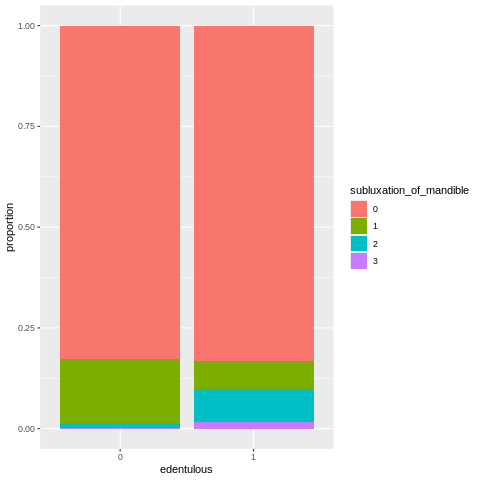

In [ ]:
%%R

temp <- df_r %>%
 group_by(edentulous, subluxation_of_mandible) %>%
  dplyr::count() %>%
  group_by(edentulous) %>%
  mutate(proportion = n/sum(n))

ggplot(temp, aes(x=edentulous,
                 y=proportion,
                 fill= subluxation_of_mandible)) +
        geom_bar(stat='identity')



In [ ]:
%%time

# RF classifier.
clf =  RandomForestClassifier(criterion='entropy',  # split criterion
                              n_estimators=400,      # Number of decsion trees
                              warm_start=False
                              )


# Store (cormack lehane) classwise classification-report
# over all 100 repeated 5-fold n_splits:
total_class0 = []  # [class0] * 100
total_class1 = []  # [[['precision', 'recall', 'f1-score', 'support'] * n_splits ] *100]
total_class2 = []  # [class2] * 100
total_class3 = []  # [class3] * 100
# To store, class-wise roc-data, for 100 attempts
all_roc_auc = []
# To store accuracy data for 100 attempts
total_acc_list = []
count = 1

print("==******************************************" )
print("Total number of folds would be: 100 X 5 = 500" )
print("==******************************************\n\n" )

# We take 5-random folds 100 times
for i in range(1):
  # To store accuracy data averaged over all classes
  list_accu_stratified = []
  # Class-wise roc-data for each of the classes for five folds
  list_roc_auc = []
  # Classwise classification report per cross-validation
  class0 = []  # class0: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class1 = []  # class1: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class2 = []  # class2: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class3 = []  # class3: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]

  # Get Stratified K-Fold cross-validator object
  skf = StratifiedKFold(
                        n_splits=5,
                        shuffle=True
                        )

  # Iterate 5-times ie once per split/fold
  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]  # y is label encoded
      print("=======")
      print("fold:", count ) ; count = count +1
      if (i < 1):
        print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
        print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Use X_train, X_test, y_train, y_test to train/evaluate model in each fold
      clf.fit(X_train, y_train)

      # 1. Get accuracy in this particular split (but averaged over all classes)
      acc = clf.score(X_test, y_test)
      print("Accuracy for this fold/split averaged over all the classes:", acc)
      list_accu_stratified.append(acc)

      # 2. Get class-wise AUC scores:
      # ovr==>One-vs-rest auc
      auc = roc_auc_score(y_test,
                          clf.predict_proba(X_test),
                          multi_class='ovr', # Ref: https://stackoverflow.com/a/66022487
                          average = None)

      print("Class-wise AUC for this fold/split:", auc)
      list_roc_auc.append(auc)

      # 3. Classification report: precision/f1/recall/support
      sk = classification_report(y_test,
                                 clf.predict(X_test),
                                 output_dict = True  # dict format and not tabular format
                                 )
      # sk['0'].values(): ['precision', 'recall', 'f1-score', 'support']
      #                   for class-0 of cormack lehane
      class0.append(list(sk['0'].values()))
      class1.append(list(sk['1'].values()))
      class2.append(list(sk['2'].values()))
      class3.append(list(sk['3'].values()))

  total_acc_list.append(list_accu_stratified)
  total_class0.append(class0)
  total_class1.append(class1)
  total_class2.append(class2)
  total_class3.append(class3)
  all_roc_auc.append(list_roc_auc)
  print(f"Mean accuracy over {i+1}-n_splits of 5-folds each : {np.mean(np.array(total_acc_list).flatten())}")

# The last fitted classifier object
randomForest_classifier = clf

==******************************************
Total number of folds would be: 100 X 5 = 500
==******************************************


fold: 1
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy for this fold/split averaged over all the classes: 0.875
Class-wise AUC for this fold/split: [0.96769231 0.94977679 0.97588315 0.9903775 ]
fold: 2
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy for this fold/split averaged over all the classes: 0.895
Class-wise AUC for this fold/split: [0.95685892 0.94688515 0.98987464 0.99851962]
fold: 3
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy for this fold/split averaged over all the classes: 0.915
Class-wise AUC for this fold/split: [0.96974359 0.96674765 0.99967856 1.        ]
fold: 4
X_train shape: (799, 12) y_train shape: (799,)
X_test shape: (199, 12) y_test shape: (199,)
Accuracy for this 

In [ ]:
from sklearn.metrics import log_loss
prob = clf.predict_proba(X_test)
prob.shape

(199, 4)

In [ ]:
prob = clf.predict_proba(X_test)
log_loss(y_test, prob)

0.3264399763337798

In [ ]:
y_test

array([0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 0, 0, 1, 1, 2, 0, 1, 1, 1, 0, 3, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 3, 1, 1, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 3, 0, 1, 1, 1,
       0, 1, 1, 2, 0, 1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1,
       0, 0, 0, 0, 1, 0, 2, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 3,
       0, 2, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 3,
       1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 0, 3, 1, 1, 1, 1, 0, 0, 2, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0,
       1])

In [ ]:
from sklearn.metrics import log_loss
y_true = [0, 2, 1, 2]
y_pred = [[.8, .1,0.1], [.2, .2, 0.6], [.3, .7,0.0], [.3,0.1,0.6]]
log_loss(y_true, y_pred)

0.4003674356962309